## Plot the 2pt for Abacus CubicBox data

In [3]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import glob
import fitsio
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter, NullFormatter
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 12
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from mockfactory import utils, DistanceToRedshift, Catalog, RandomBoxCatalog
from cosmoprimo.fiducial import DESI, AbacusSummit
from pycorr import TwoPointCorrelationFunction
from pycorr import project_to_multipoles, project_to_wp
from pypower import CatalogFFTPower, PowerSpectrumMultipoles, setup_logging
from pyrecon import MultiGridReconstruction, IterativeFFTReconstruction, IterativeFFTParticleReconstruction, utils, setup_logging

In [4]:
sys.path.append('/global/homes/s/shengyu/project_rc/main/Y3/')
from helper import REDSHIFT_VSMEAR, REDSHIFT_CUBICBOX, EDGES, RSF_CUBIC_ERROR, RSF_COV_ERROR, RSF_EZMOCKS_ERROR, GET_RECON_BIAS
from helper import REDSHIFT_LSS_VSMEAR, REDSHIFT_LSS_CUBICBOX, COLOR_TRACERS, Y3_EFFECTIVE_VOLUME
from fit_cubic_tools import load_bins, load_rescalc_cov, load_mock_cov, load_EZcov_fn
%load_ext autoreload
%autoreload 2
     
Z_VSMEAR = REDSHIFT_LSS_VSMEAR # REDSHIFT_VSMEAR or REDSHIFT_LSS_VSMEAR (LSS z bins)
Z_CUBIC = REDSHIFT_LSS_CUBICBOX # REDSHIFT_CUBICBOX or REDSHIFT_LSS_CUBICBOX

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
for tracer in ['BGS','LRG','ELG','QSO']:
    for v_eff in Y3_EFFECTIVE_VOLUME[tracer]:
        print(tracer,(1.5*0.6736)**3/v_eff)
        # print(tracer,np.sqrt((1.5*0.6736)**3/v_eff))

BGS 0.2714541065431579
LRG 0.21051542956408156
LRG 0.13572705327157894
LRG 0.10525771478204078
ELG 0.177849242217931
ELG 0.1242801933571084
QSO 0.3820465203199999


In [ ]:
# PLOT THE 2PCF (TWO-POINT CORRELATION FUNCTION)
setup_logging(level='warning')
corr_type = 'xi'
bins_type = 'test' # test, y3_bao
(rmin, rmax, rbin, lenr) = load_bins('xi', bins_type)

sys_models = ['standard','dv-obs']
error_type = 'standard' #standard, covbox, rescalc
tracers = ['BGS']
# tracers = ['BGS','LRG', 'ELG', 'QSO']
mockids = range(0,25)
recon = False

for tracer in tracers:
    lenfig = len(Z_VSMEAR[tracer])
    fig, ax = plt.subplots(3, lenfig, figsize = (lenfig*4,5), sharex=True, gridspec_kw={'height_ratios': [2,1,1]})
    if lenfig == 1:
        ax = ax[:, np.newaxis] 
    fig.subplots_adjust(wspace=0.03, hspace=0.05)
    for i,(zmin, zmax) in enumerate(Z_VSMEAR[tracer]):
        z_eff = Z_CUBIC[tracer][i]
        color = COLOR_TRACERS[tracer][i] 
        data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "recon": recon, "grid_cosmo": "000"}
        xi_dv_obs = []
        xi_standard = []
        for sys_model in sys_models:
            for mock_id in mockids:
                mock_id03 =  f"{mock_id:03}"
                base_dir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/{tracer}/obs_z{zmin:.1f}-{zmax:.1f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                if recon == False:
                    result_fn = base_dir+f'/xipoles_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}.npy'
                if recon == True:
                    result_fn =base_dir+f'/xipoles_recon_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}.npy'
                result = TwoPointCorrelationFunction.load(result_fn)
                result = result[::rbin,::]
                result.select((rmin, rmax))
                r, xi = project_to_multipoles(result, ells=[0,2])
                if sys_model in ['dv-obs']:
                    xi_dv_obs.append(xi)
                if sys_model in ['standard']:
                    xi_standard.append(xi)
        xi_standard = [np.mean(xi_standard, axis=0), np.std(xi_standard, axis=0)]
        xi_dv_obs = [np.mean(xi_dv_obs, axis=0), np.std(xi_dv_obs, axis=0)]
        if error_type == 'standard':
            # rsf = RSF_CUBIC_ERROR[tracer][Z_VSMEAR[tracer].index((zmin, zmax))]
            error_rsf = RSF_CUBIC_ERROR[tracer][i]
            error = [xi_standard[1][0]*error_rsf, xi_standard[1][1]*error_rsf]
        # elif error_type == 'rescalc':
        #     cov = load_rescalc_cov(data_args, bins_type)
        #     error = [np.sqrt(np.diag(cov))[:lenr], np.sqrt(np.diag(cov))[lenr:2*lenr]]
        # elif error_type == 'covbox':
        #     rsf = RSF_COV_ERROR[tracer][Z_VSMEAR[tracer].index((zmin, zmax))]
        #     error = np.loadtxt(f"/global/homes/s/shengyu/project_rc/main/Y3/data/errorbar/error_covbox_xi_{tracer}_z{z_eff:.1f}.txt")
        #     error = [error[:,0]*rsf, error[:,1]*rsf]
        for t in range(3):
            if t == 0:
                for ell in range(2):
                    ax[t][i].plot(r, r**2*xi_standard[0][ell],color='black', lw=1.0)
                    ax[t][i].plot(r, r**2*xi_dv_obs[0][ell],color=color, lw=1.0)
                label = f'{tracer} z{zmin}-{zmax}'
                line= Line2D([0], [0], label=label, color='none', alpha=0)
                loc = 'center left' if bins_type == 'y3_bao' else 1
                leg1 = ax[0][i].legend(handles=[line], loc=loc, fontsize=14)
                leg1.get_frame().set_linewidth(0.0)
                if i ==0:
                    ax[t][i].set_ylabel(r'$s^2\xi_{\ell}$')
            if t == 1:
                ell = 0
                ax[t][i].plot(r, (xi_dv_obs[0][ell]-xi_standard[0][ell])/error[ell],color=color)
                if i ==0:
                    ax[t][i].set_ylabel(r'$\Delta \xi_0/\sigma_{Y3}$')
            if t == 2:
                ell = 1
                ax[t][i].plot(r, (xi_dv_obs[0][ell]-xi_standard[0][ell])/error[ell],color=color)
                if i ==0:
                    ax[t][i].set_ylabel(r'$\Delta \xi_2/\sigma_{Y3}$')
                ax[t][i].set_xlabel(r'$s$')
            if t ==1 or t==2:
                ax[t][i].fill_between(r, -1 , 1, color = '#d1e7f7', alpha=0.2)
                ax[t][i].axhline(y=1, color = 'black', ls='--')
                ax[t][i].axhline(y=-1, color = 'black', ls='--')
                ax[t][i].axhline(y=0, color='black', lw=0.6)
                ax[t][i].set_ylim([-3,3])
            if i>0:
                ax[t][i].tick_params(axis='y', which='both', left=False, labelleft=False)

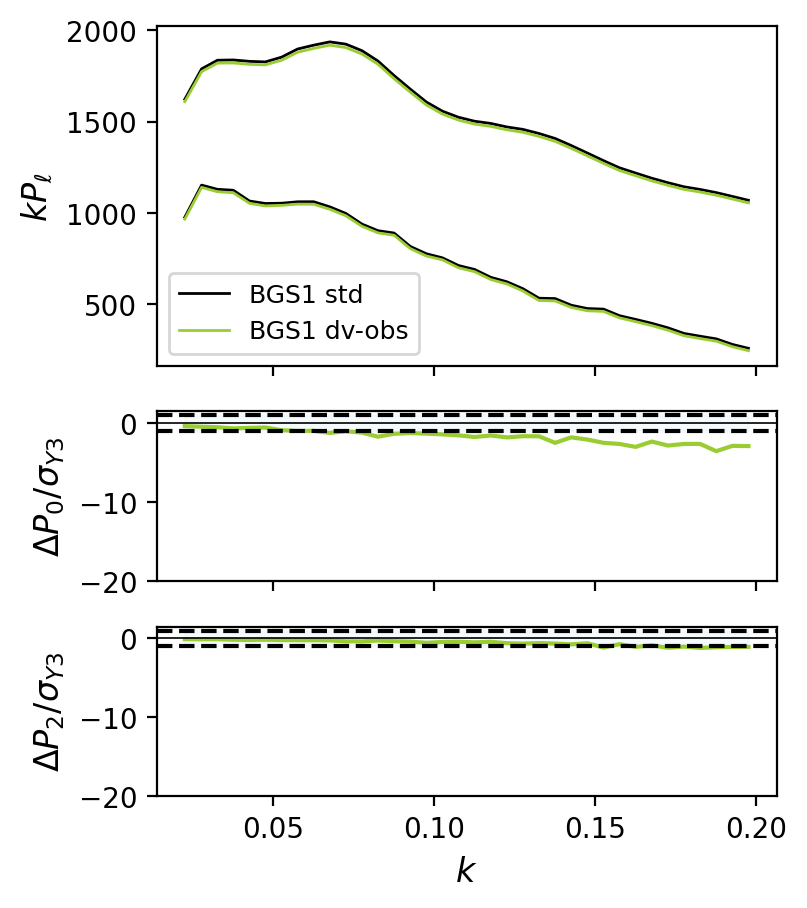

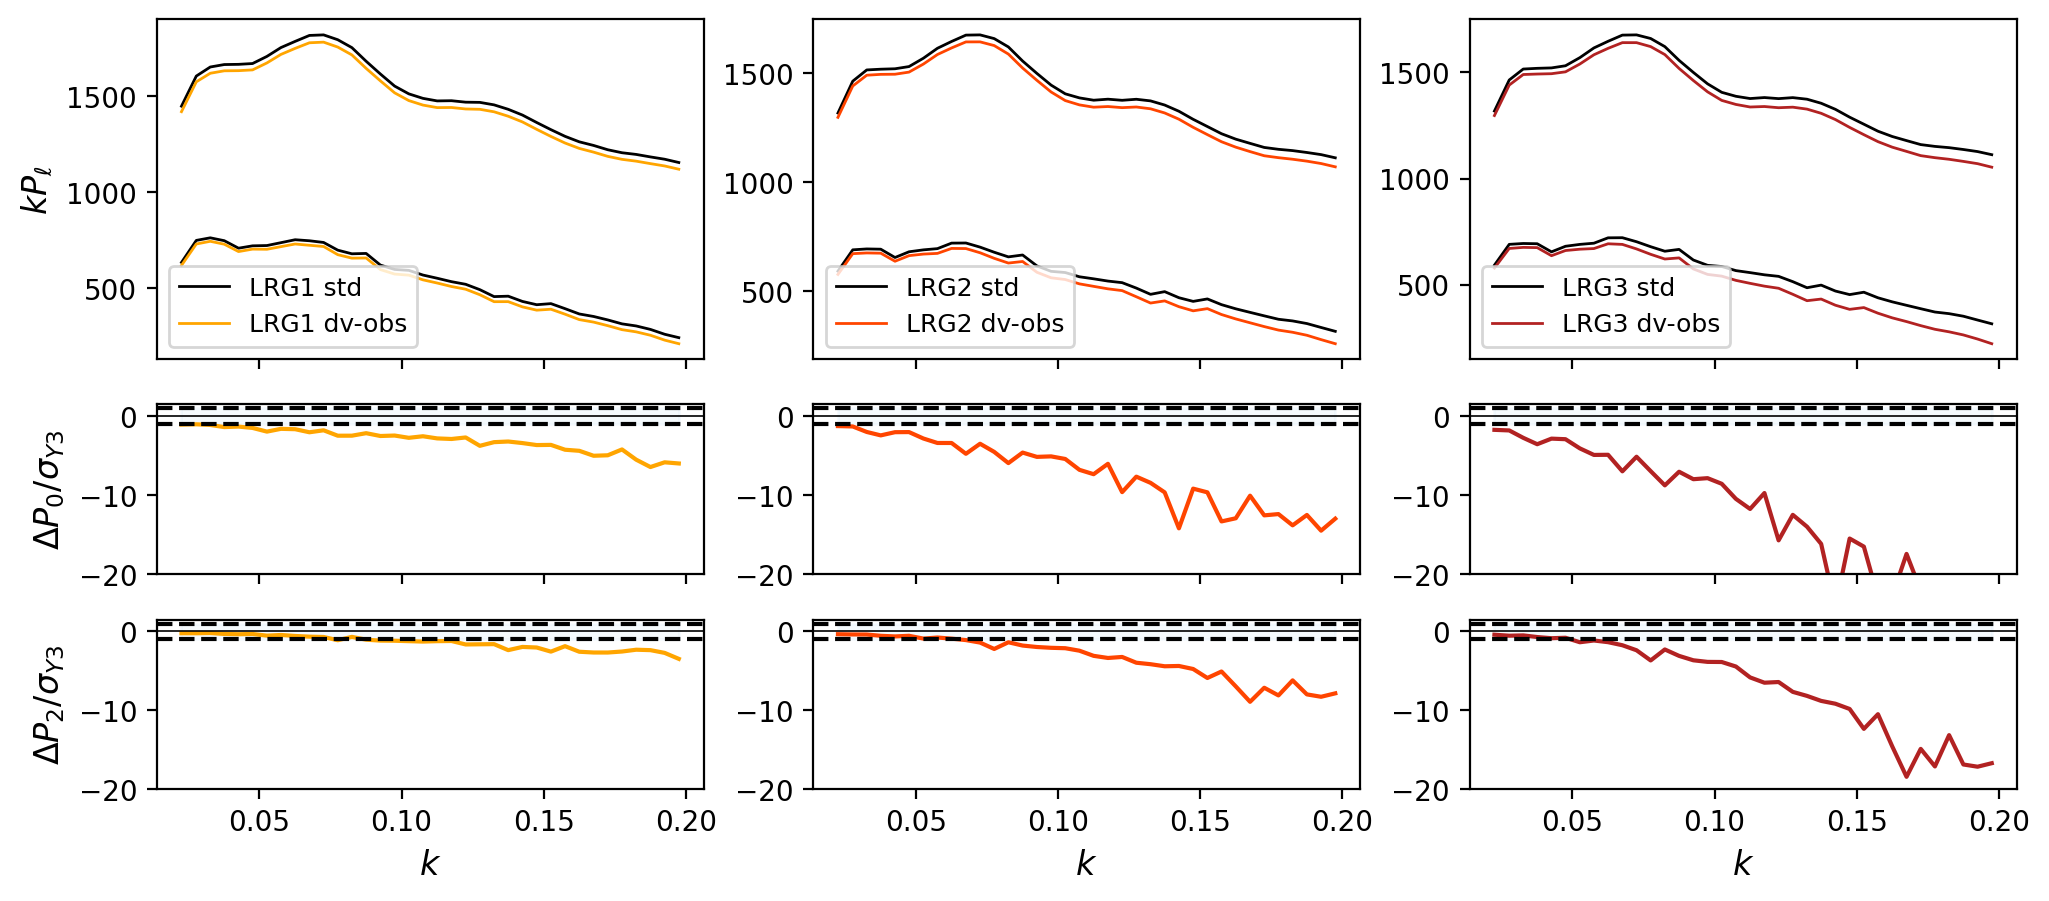

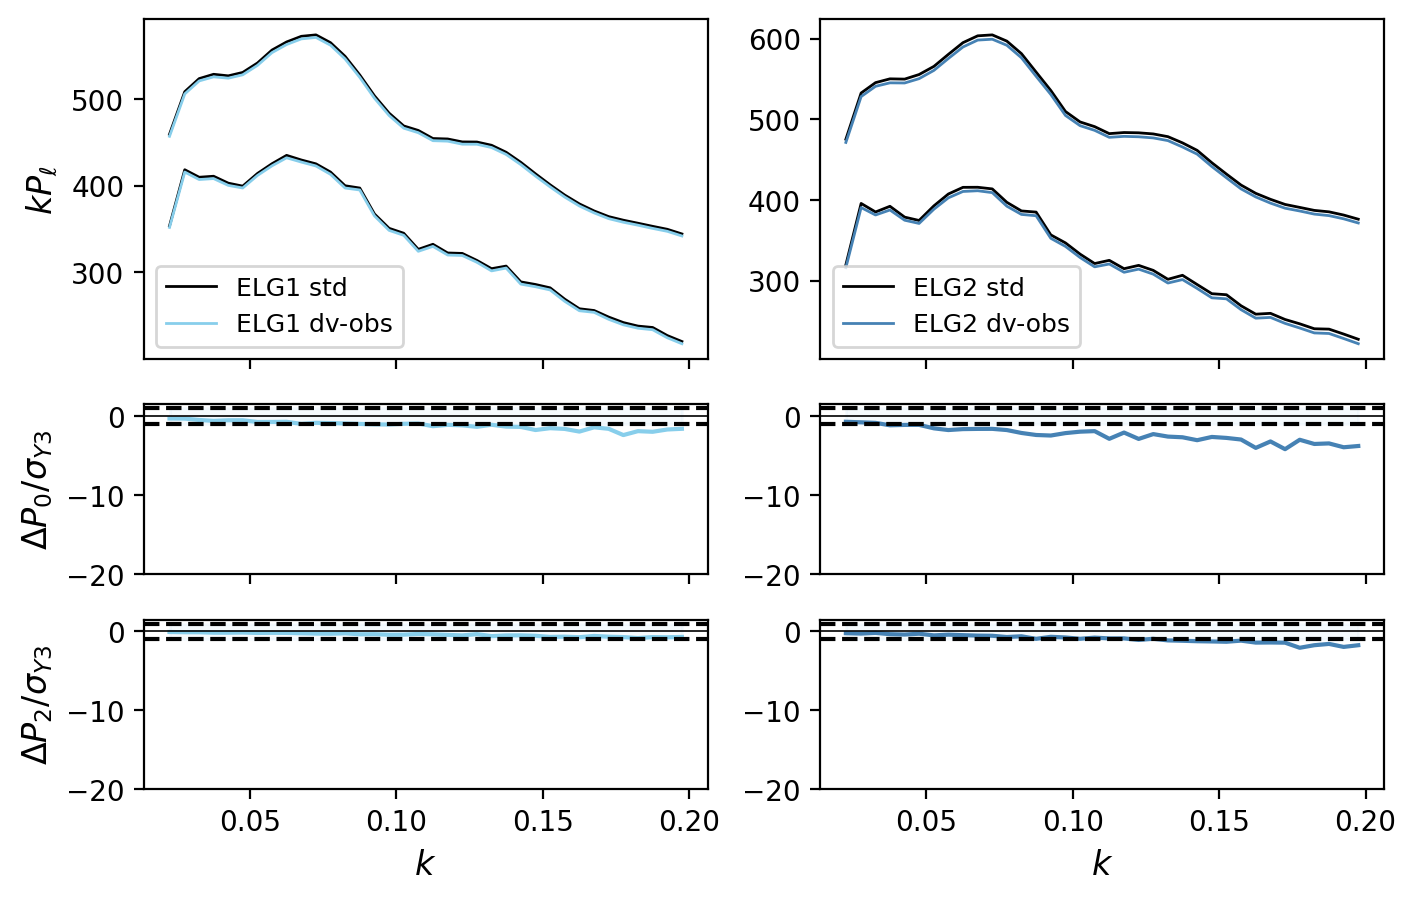

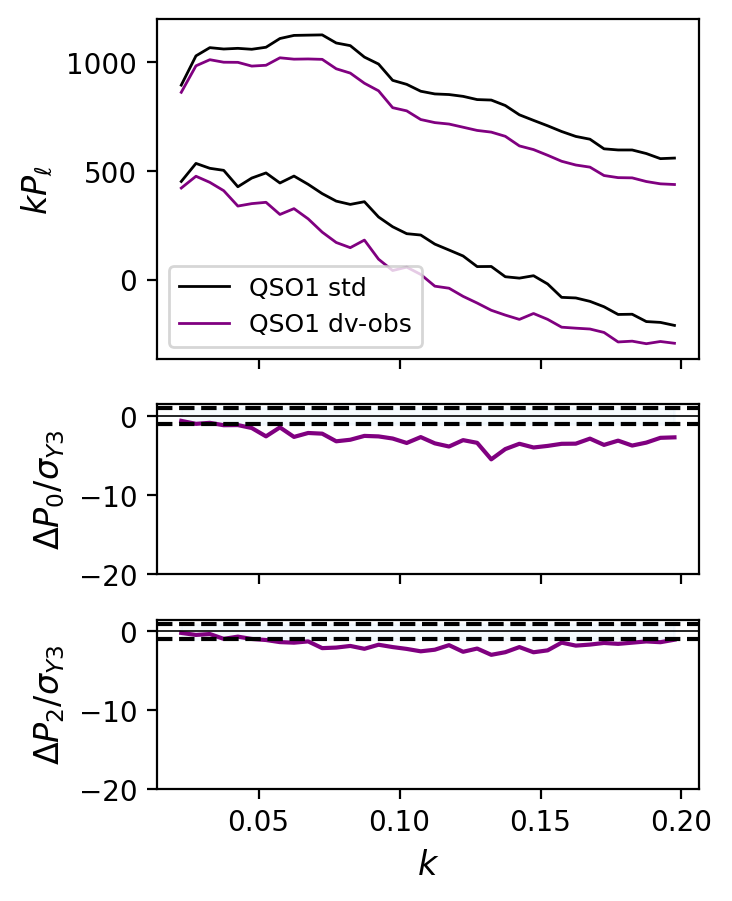

In [ ]:
# PLOT THE PK
corr_type = 'pk' 
bins_type = 'y3_sys' # test, y3_bao, y3_sys
(kmin, kmax, kbin, lenk) = load_bins('pk', bins_type)

sys_models = ['standard','dv-obs']
error_type = 'standard' #standard, covbox, EZcov

# tracers = ['LRG','QSO']
tracers = ['BGS','LRG', 'ELG', 'QSO']
mockids = range(0,25)
recon = False

for tracer in tracers:
    lenfig = len(Z_VSMEAR[tracer])
    if tracer == 'QSO':
        fig, ax = plt.subplots(3, lenfig, figsize = (lenfig*3.5,5), sharex=True, gridspec_kw={'height_ratios': [2,1,1]})
    else:
        fig, ax = plt.subplots(3, lenfig, figsize = (lenfig*4,5), sharex=True, gridspec_kw={'height_ratios': [2,1,1]})
    if lenfig == 1:
        ax = ax[:, np.newaxis]
    for i,(zmin, zmax) in enumerate(Z_VSMEAR[tracer]):
        z_eff = Z_CUBIC[tracer][i]
        color = COLOR_TRACERS[tracer][i] 
        pk_dv_obs = []
        pk_standard = []
        for sys_model in sys_models:
            for mock_id in mockids:
                mock_id03 =  f"{mock_id:03}"
                base_dir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/{tracer}/obs_z{zmin:.1f}-{zmax:.1f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                if recon == False:
                    result_fn = base_dir+f'/pkpoles_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}.npy'
                if recon == True:
                    result_fn =base_dir+f'/pkpoles_recon_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}.npy'
                result = PowerSpectrumMultipoles.load(result_fn)
                result = result.select((kmin,kmax,kbin))
                pk = np.real(result.get_power())
                ks = result.kavg
                if sys_model in ['dv-obs']:
                    pk_dv_obs.append(pk)
                if sys_model in ['standard']:
                    pk_standard.append(pk)
        pk_standard = [np.mean(pk_standard, axis=0), np.std(pk_standard, axis=0)]
        pk_dv_obs = [np.mean(pk_dv_obs, axis=0), np.std(pk_dv_obs, axis=0)]
        if error_type == 'standard':
            rsf = RSF_CUBIC_ERROR[tracer][Z_VSMEAR[tracer].index((zmin, zmax))]
            error = [pk_standard[1][0]*rsf, pk_standard[1][1]*rsf]
        elif error_type == 'covbox':
            rsf = RSF_COV_ERROR[tracer][Z_VSMEAR[tracer].index((zmin, zmax))]
            error = np.loadtxt(f"/global/homes/s/shengyu/project_rc/main/Y3/data/errorbar/error_covbox_pk_{tracer}_z{z_eff:.1f}.txt")
            error = [error[:,0]*rsf, error[:,1]*rsf]
        elif error_type == 'EZcov':
            data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "grid_cosmo": '000'}
            cov_mock = load_EZcov_fn(data_args,  cov_type='EZmocks', corr_type = corr_type, bins_type = 'y3_sys', rsf = True)
            error = [np.sqrt(np.diag(cov_mock))[:lenk], np.sqrt(np.diag(cov_mock))[lenk:2*lenk]]
        for t in range(3):
            if t == 0:
                for ell in range(2):
                    ax[t][i].plot(ks, ks*pk_standard[0][ell],color='black', lw=1.0, label = f'{tracer}{i+1} std')
                    ax[t][i].plot(ks, ks*pk_dv_obs[0][ell],color=color, lw=1.0, label = f'{tracer}{i+1} dv-obs')
                    if ell == 0:
                        ax[t][i].legend(loc=3, fontsize=9)
                # label = f'{tracer} z{zmin}-{zmax}'
                # line= Line2D([0], [0], label=label, color='none', alpha=0)
                # loc = 1
                # leg1 = ax[0][i].legend(handles=[line], loc=loc, fontsize=14)
                # leg1.get_frame().set_linewidth(0.0)
                if i ==0:
                    ax[t][i].set_ylabel(r'$kP_{\ell}$')
            if t == 1:
                ell = 0
                ax[t][i].plot(ks, (pk_dv_obs[0][ell]-pk_standard[0][ell])/error[ell],color=color)
                if i ==0:
                    ax[t][i].set_ylabel(r'$\Delta P_0/\sigma_{Y3}$')
            if t == 2:
                ell = 1
                ax[t][i].plot(ks, (pk_dv_obs[0][ell]-pk_standard[0][ell])/error[ell],color=color)
                if i ==0:
                    ax[t][i].set_ylabel(r'$\Delta P_2/\sigma_{Y3}$')
                ax[t][i].set_xlabel(r'$k$')
            if t ==1 or t==2:
                ax[t][i].fill_between(ks, -1 , 1, color = '#d1e7f7', alpha=0.2)
                ax[t][i].axhline(y=1, color = 'black', ls='--')
                ax[t][i].axhline(y=-1, color = 'black', ls='--')
                ax[t][i].axhline(y=0, color='black', lw=0.6)
                ax[t][i].set_ylim([-20,1.5])
            # if i>0:
                # ax[t][i].tick_params(axis='y', which='both', left=False, labelleft=False)

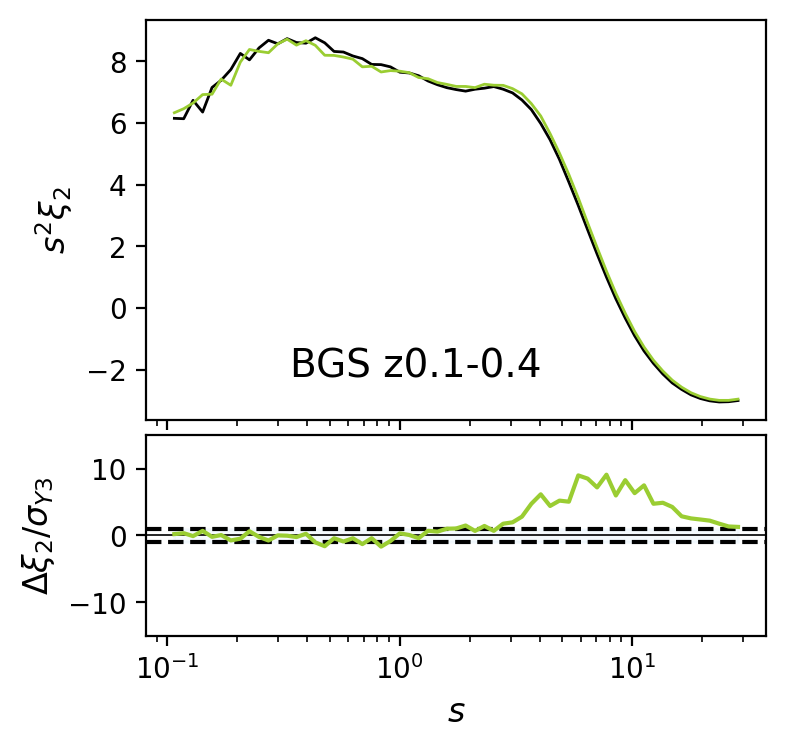

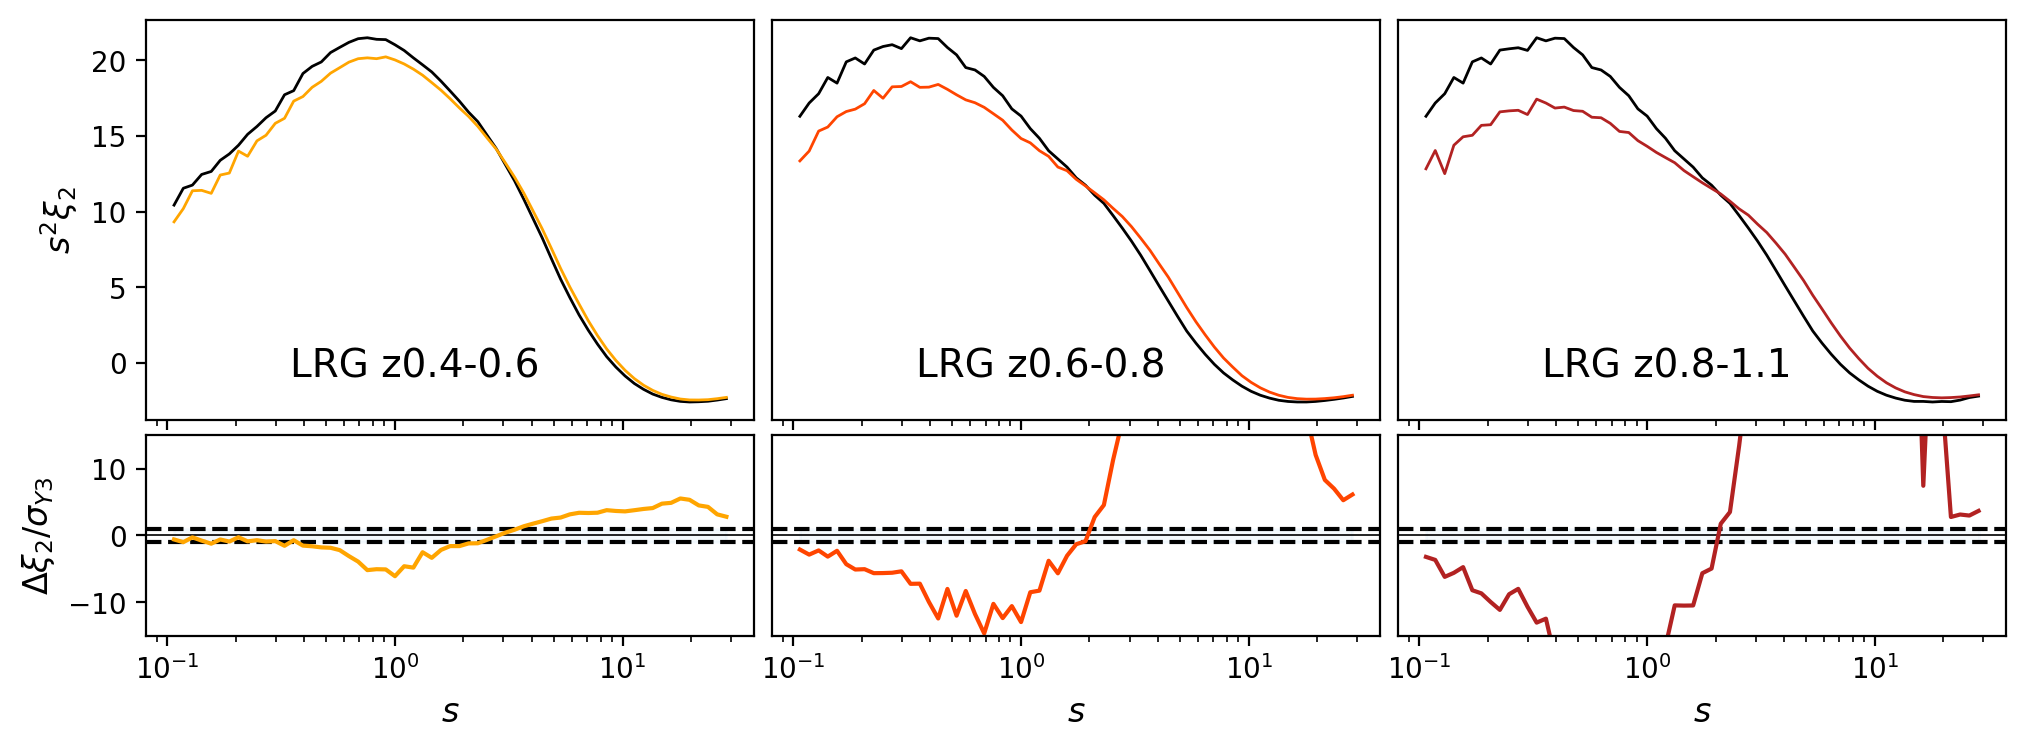

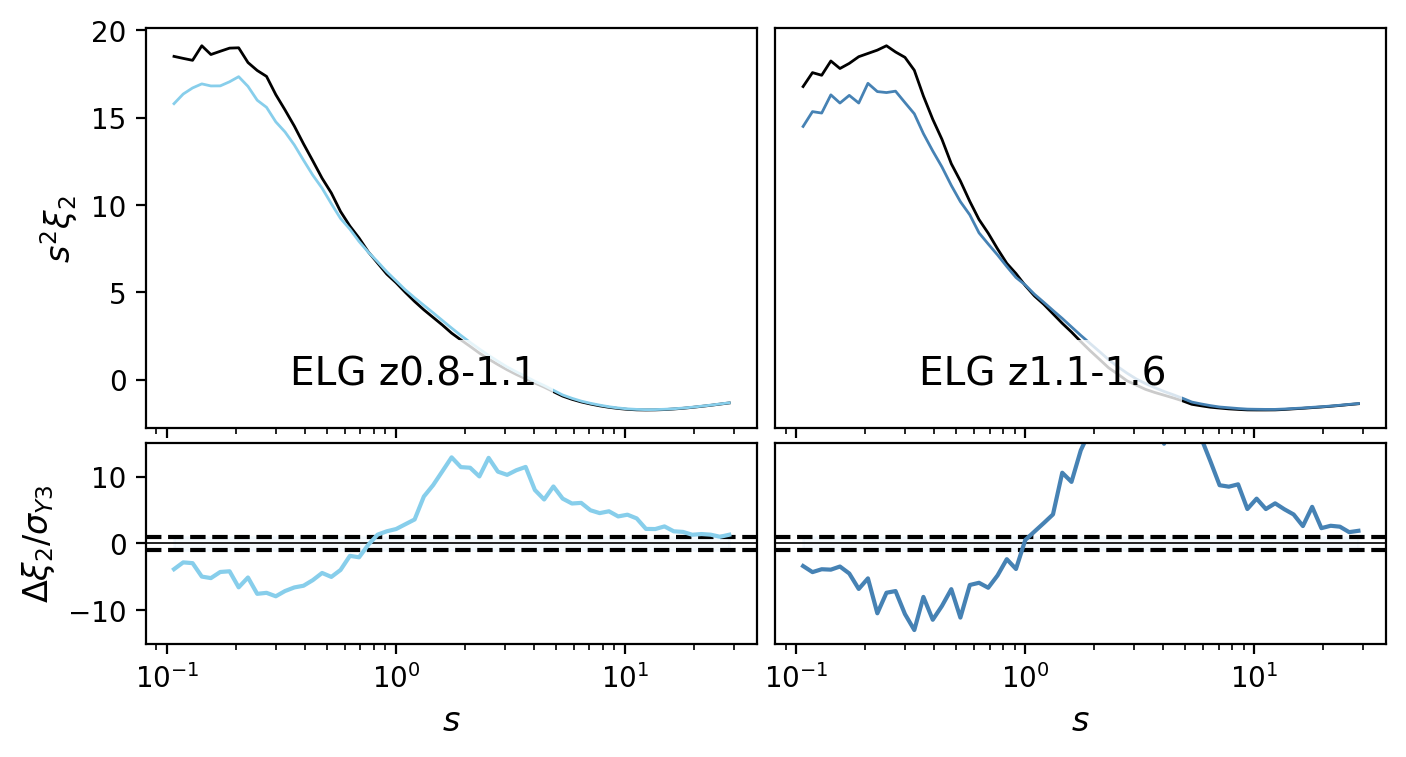

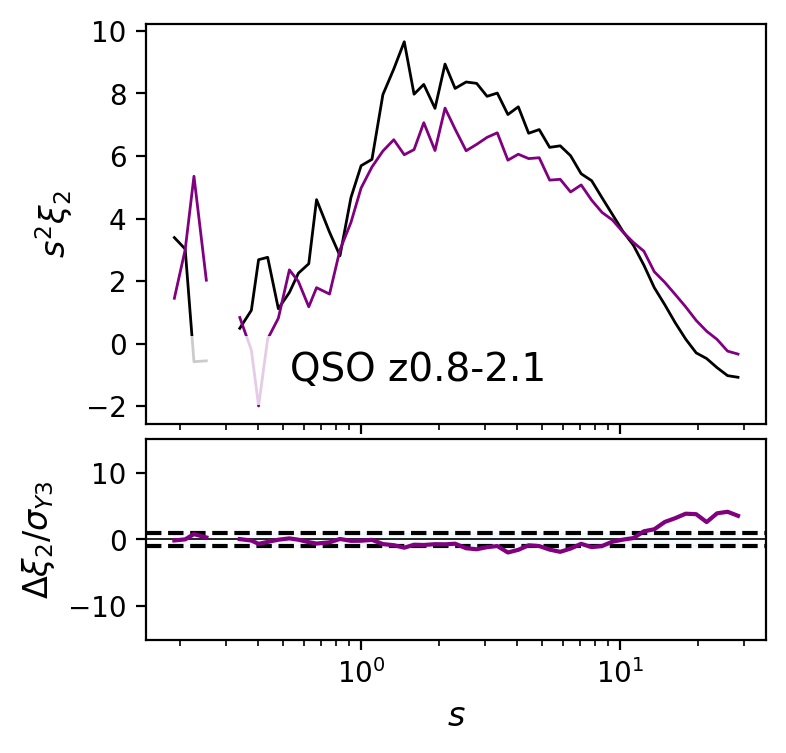

In [7]:
#plot the xi0 and xi2 for HOD fitting
bins_type = 'test' # test, y3_bao
(smin, smax, sbin, slen) = load_bins('mpslog')

sys_models = ['standard','dv-obs']
# tracers = ['BGS']
tracers = ['BGS','LRG', 'ELG', 'QSO']
mockids = range(0,25)
ell = 1

for tracer in tracers:
    lenfig = len(Z_VSMEAR[tracer])
    if tracer == 'QSO':
        fig, ax = plt.subplots(2, lenfig, figsize = (lenfig*4,4), sharex=True, gridspec_kw={'height_ratios': [2,1]})
    else:
        fig, ax = plt.subplots(2, lenfig, figsize = (lenfig*4,4), sharex=True, gridspec_kw={'height_ratios': [2,1]})
    if lenfig == 1:
        ax = ax[:, np.newaxis] 
    fig.subplots_adjust(wspace=0.03, hspace=0.05) 
    for i,(zmin, zmax) in enumerate(Z_VSMEAR[tracer]):
        color = COLOR_TRACERS[tracer][i] 
        mps_dv_obs = []
        mps_dv_standard = []
        for sys_model in sys_models:
            for mock_id in mockids:
                mock_id03 =  f"{mock_id:03}"
                base_dir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/{tracer}/obs_z{zmin:.1f}-{zmax:.1f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                result_fn = base_dir+f'/mpslog_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}.npy'
                result = TwoPointCorrelationFunction.load(result_fn)
                result.select((smin, smax))
                s, mps = project_to_multipoles(result, ells=[0,2])
                if sys_model in ['dv-obs']:
                    mps_dv_obs.append(mps)
                if sys_model in ['standard']:
                    mps_dv_standard.append(mps)
        mps_dv_standard = [np.mean(mps_dv_standard, axis=0), np.std(mps_dv_standard, axis=0)]
        mps_dv_obs = [np.mean(mps_dv_obs, axis=0), np.std(mps_dv_obs, axis=0)]
        error_rsf  = RSF_CUBIC_ERROR[tracer][Z_VSMEAR[tracer].index((zmin, zmax))]
        mps_standard_error = [mps_dv_standard[1][0]*error_rsf, mps_dv_standard[1][1]*error_rsf]        
        error = mps_standard_error
        for t in range(2):
            if t == 0:
                ax[t][i].plot(s, s*mps_dv_standard[0][ell],color='black', lw=1.0)
                ax[t][i].plot(s, s*mps_dv_obs[0][ell],color=color, lw=1.0)
                label = f'{tracer} z{zmin}-{zmax}'
                line= Line2D([0], [0], label=label, color='none', alpha=0)
                # loc = 'lower center'
                loc = 3
                leg1 = ax[0][i].legend(handles=[line], loc=loc, fontsize=14)
                leg1.get_frame().set_linewidth(0.0)
                if i ==0:
                    if ell == 0:
                        ax[t][i].set_ylabel(r'$s^2\xi_0$')
                    if ell == 1:
                        ax[t][i].set_ylabel(r'$s^2\xi_2$')    
                    ax[0][0].set_xscale('log')
            if t == 1:
                ax[t][i].fill_between(s, -1 , 1, color = '#d1e7f7', alpha=0.2)
                ax[t][i].axhline(y=1, color = 'black', ls='--')
                ax[t][i].axhline(y=-1, color = 'black', ls='--')
                ax[t][i].axhline(y=0, color='black', lw=0.6)
                if ell == 0:
                    ax[1][i].plot(s, (mps_dv_obs[0][ell]-mps_dv_standard[0][ell])/error[ell],color=color)
                    ax[t][0].set_ylabel(r'$\Delta \xi_0/\sigma_{Y3}$')
                    ax[t][i].set_ylim([-25,1.5])
                if ell == 1:
                    ax[1][i].plot(s, (mps_dv_obs[0][ell]-mps_dv_standard[0][ell])/error[ell],color=color)
                    ax[t][0].set_ylabel(r'$\Delta \xi_2/\sigma_{Y3}$')
                    ax[t][i].set_ylim([-15,15])
                ax[t][i].set_xlabel(r'$s$')
            if i>0:
                ax[t][i].tick_params(axis='y', which='both', left=False, labelleft=False)

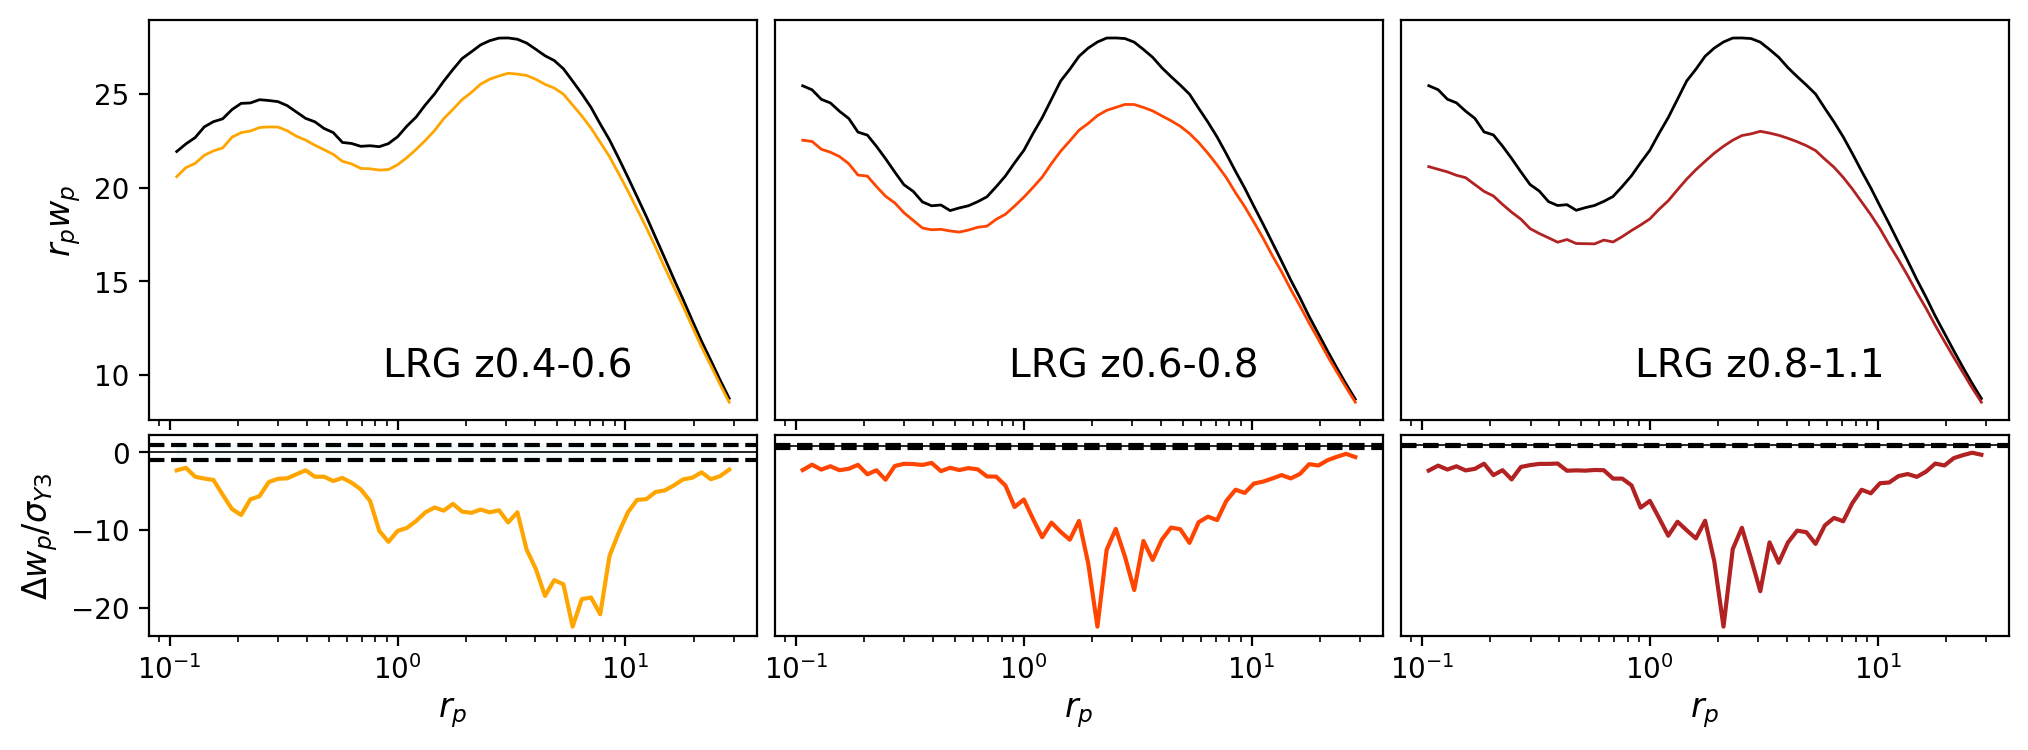

In [6]:
# PLOT THE WP (PROJECTED CORRELATION FUNCTION)
bins_type = 'test' # test, y3_bao
(pmin, pmax, _, _) = load_bins('wp')

sys_models = ['standard','dv-obs']
# tracers = ['BGS']
tracers = ['LRG']
mockids = range(0,25)

for tracer in tracers:
    lenfig = len(Z_VSMEAR[tracer])
    if tracer == 'QSO':
        fig, ax = plt.subplots(2, lenfig, figsize = (lenfig*4,4), sharex=True, gridspec_kw={'height_ratios': [2,1]})
    else:
        fig, ax = plt.subplots(2, lenfig, figsize = (lenfig*4,4), sharex=True, gridspec_kw={'height_ratios': [2,1]})
    if lenfig == 1:
        ax = ax[:, np.newaxis] 
    fig.subplots_adjust(wspace=0.03, hspace=0.05) 
    for i,(zmin, zmax) in enumerate(Z_VSMEAR[tracer]):
        color = COLOR_TRACERS[tracer][i] 
        wp_dv_obs = []
        wp_standard = []
        for sys_model in sys_models:
            for mock_id in mockids:
                mock_id03 =  f"{mock_id:03}"
                base_dir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/{tracer}/obs_z{zmin:.1f}-{zmax:.1f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                result_fn = base_dir+f'/wplog_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}.npy'
                result = TwoPointCorrelationFunction.load(result_fn)
                result.select((pmin, pmax))
                p,wp = project_to_wp(result)
                if sys_model in ['dv-obs']:
                    wp_dv_obs.append(wp)
                if sys_model in ['standard']:
                    wp_standard.append(wp)
        wp_standard = [np.mean(wp_standard, axis=0), np.std(wp_standard, axis=0)]
        wp_dv_obs = [np.mean(wp_dv_obs, axis=0), np.std(wp_dv_obs, axis=0)]
        error_rsf = RSF_CUBIC_ERROR[tracer][i]
        wp_standard_error = wp_standard[1]*error_rsf      
        error = wp_standard_error
        for t in range(2):
            if t == 0:
                ax[t][i].plot(p, p*wp_standard[0],color='black', lw=1.0)
                ax[t][i].plot(p, p*wp_dv_obs[0],color=color, lw=1.0)
                label = f'{tracer} z{zmin}-{zmax}'
                line= Line2D([0], [0], label=label, color='none', alpha=0)
                # loc = 2
                loc = 'lower center'
                leg1 = ax[0][i].legend(handles=[line], loc=loc, fontsize=14)
                leg1.get_frame().set_linewidth(0.0)
                if i == 0:
                    ax[t][i].set_ylabel(r'$r_p w_p$')
                    ax[t][i].set_xscale('log')
            if t == 1:
                ax[1][i].plot(p, (wp_dv_obs[0]-wp_standard[0])/error,color=color)
                ax[t][i].fill_between(p, -1 , 1, color = '#d1e7f7', alpha=0.2)
                ax[t][i].axhline(y=1, color = 'black', ls='--')
                ax[t][i].axhline(y=-1, color = 'black', ls='--')
                ax[t][i].axhline(y=0, color='black', lw=0.6)
                ax[t][i].set_xlabel(r'$r_p$')
                if i == 0:
                    ax[t][0].set_ylabel(r'$\Delta w_p/\sigma_{Y3}$')
            if i>0:
                ax[t][i].tick_params(axis='y', which='both', left=False, labelleft=False)

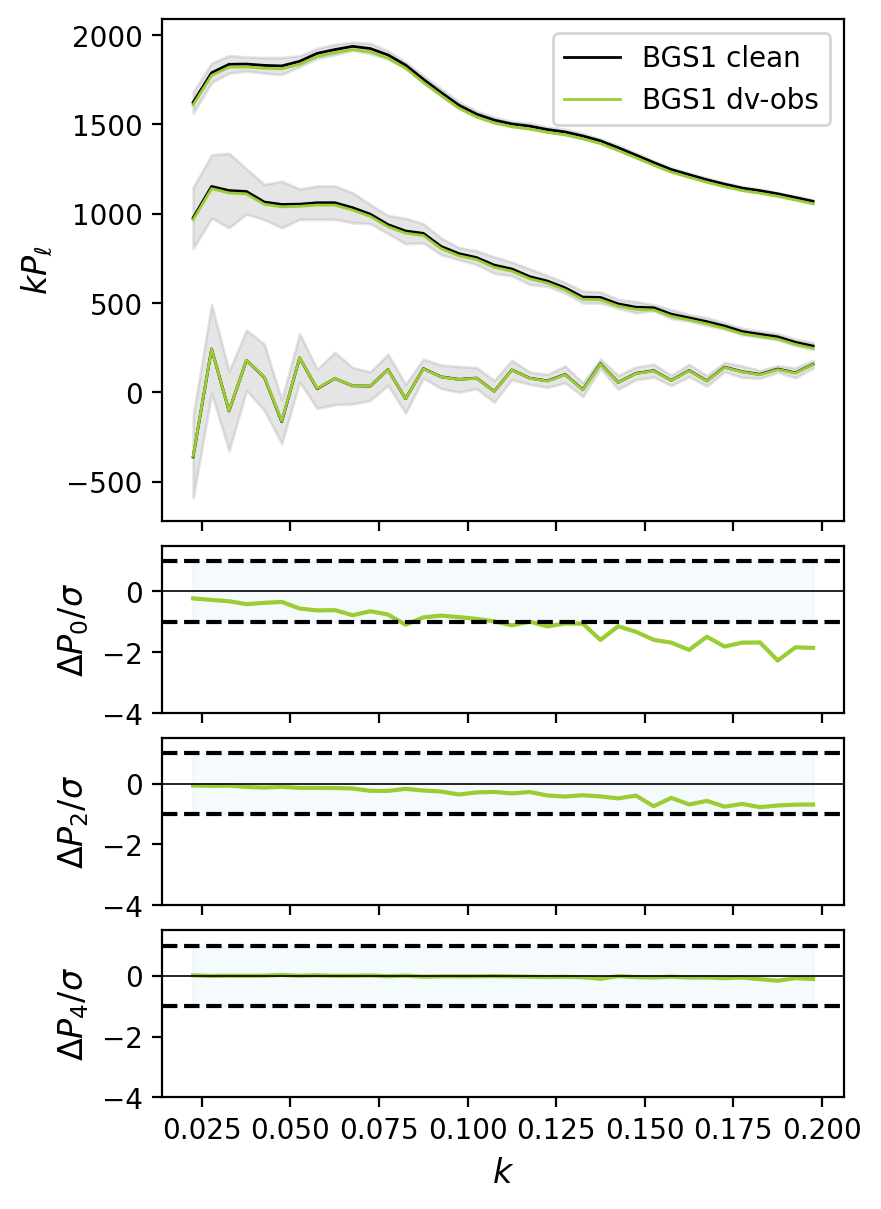

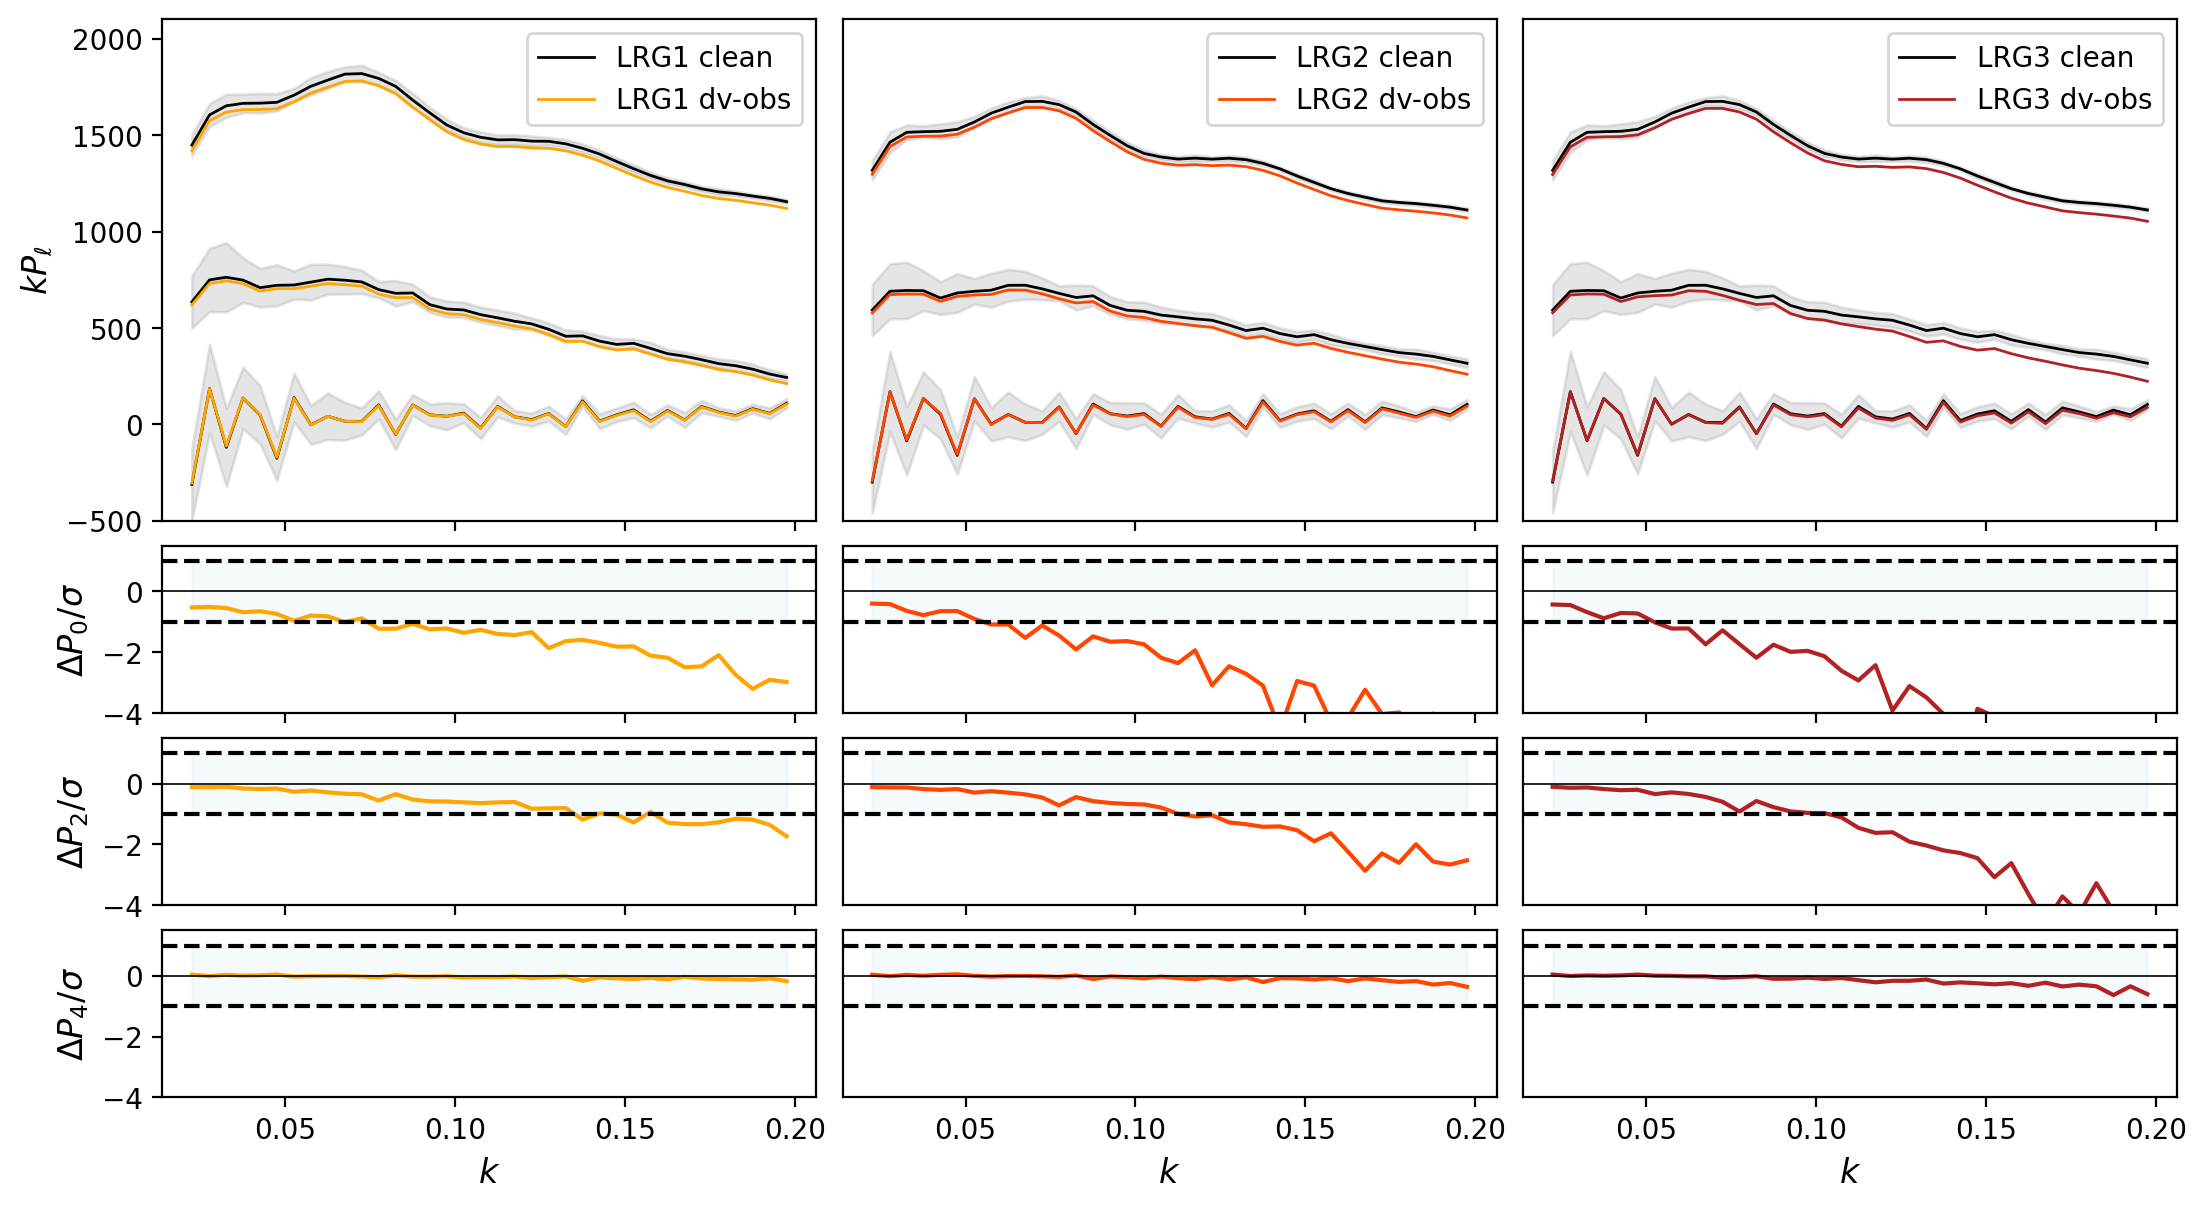

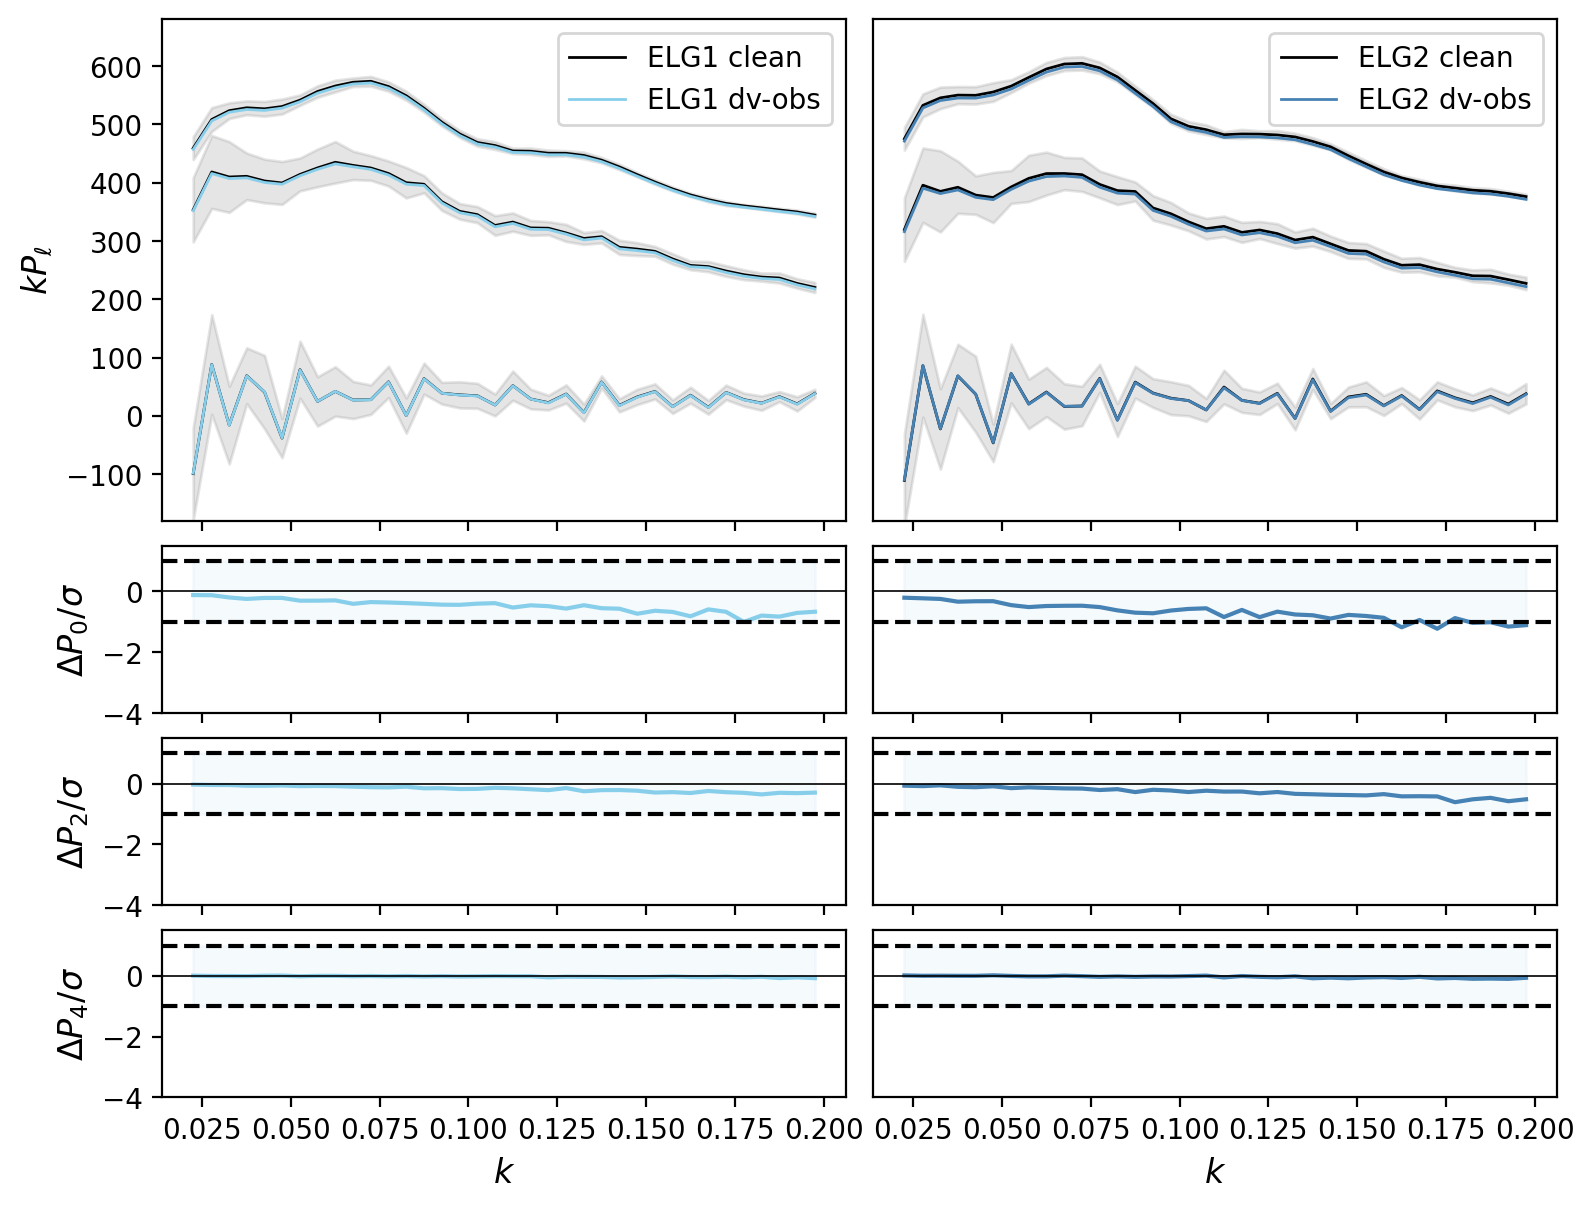

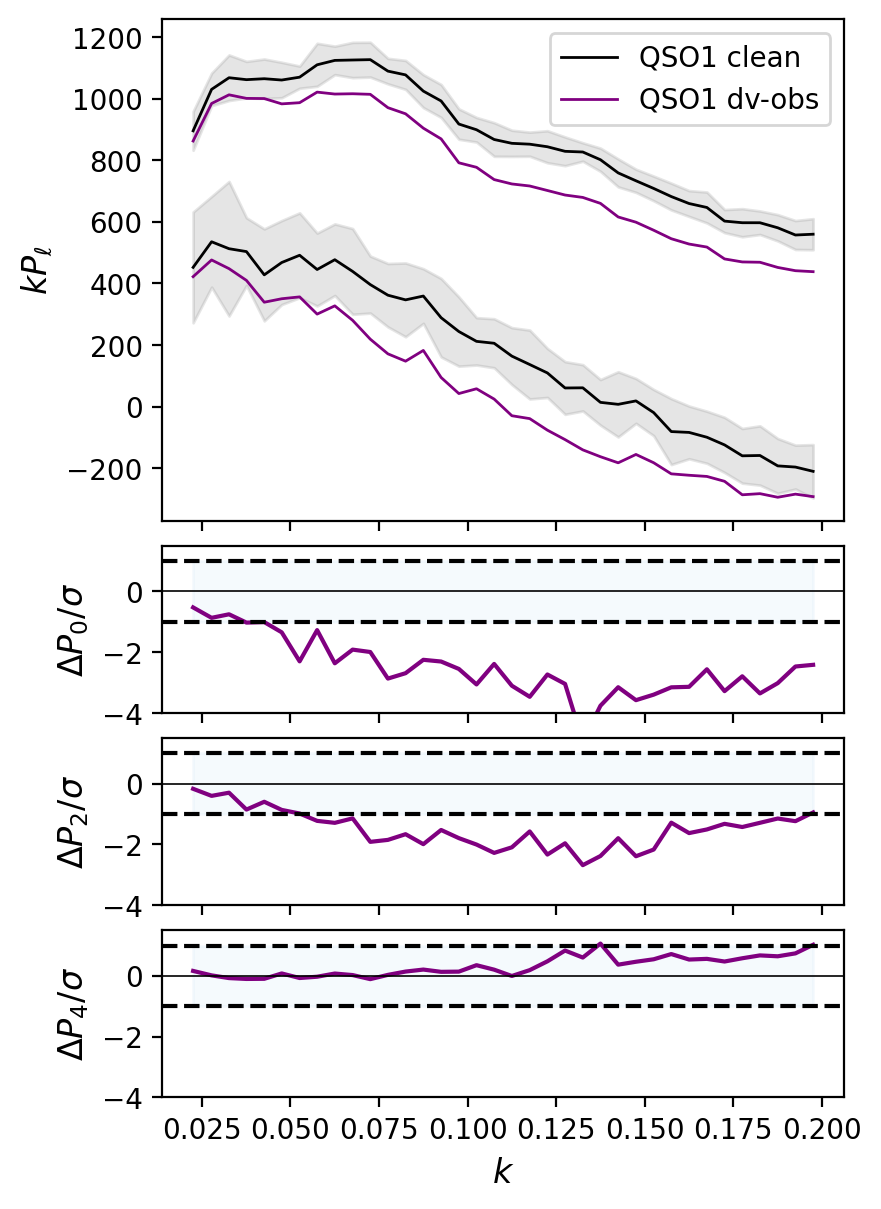

In [ ]:
# PLOT THE Pk0 Pk2 and Pk4
(kmin, kmax, kbin, lenk) = load_bins('pk', 'y3_sys')

sys_models = ['standard','dv-obs']
error_type = 'standard' #standard, covbox, EZcov

tracers = ['BGS','LRG','ELG','QSO']
mockids = range(0,25)

for tracer in tracers:
    lenfig = len(Z_VSMEAR[tracer])
    if tracer in ['BGS','QSO']:
        fig, ax = plt.subplots(4, lenfig, figsize = (lenfig*3.4+1,7), sharex=True, gridspec_kw={'height_ratios': [3,1,1,1]})
        mll = 3
        if tracer == 'QSO': mll = 2
    else:
        fig, ax = plt.subplots(4, lenfig, figsize = (lenfig*4+1,7), sharex=True, gridspec_kw={'height_ratios': [3,1,1,1]})
        mll = 3
    fig.subplots_adjust(hspace=0.1, wspace=0.04)
    if lenfig == 1:
        ax = ax[:, np.newaxis]
    for i,(zmin, zmax) in enumerate(Z_VSMEAR[tracer]):
        z_eff = Z_CUBIC[tracer][i]
        color = COLOR_TRACERS[tracer][i] 
        pk_dv_obs = []
        pk_standard = []
        for sys_model in sys_models:
            for mock_id in mockids:
                mock_id03 =  f"{mock_id:03}"
                base_dir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/{tracer}/obs_z{zmin:.1f}-{zmax:.1f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                result_fn = base_dir+f'/pkpoles_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}.npy'
                result = PowerSpectrumMultipoles.load(result_fn)
                result = result.select((kmin,kmax,kbin))
                pk = np.real(result.get_power())
                ks = result.kavg
                if sys_model in ['dv-obs']:
                    pk_dv_obs.append(pk)
                if sys_model in ['standard']:
                    pk_standard.append(pk)
        pk_standard = [np.mean(pk_standard, axis=0), np.std(pk_standard, axis=0)]
        pk_dv_obs = [np.mean(pk_dv_obs, axis=0), np.std(pk_dv_obs, axis=0)]
        error = [pk_standard[1][0], pk_standard[1][1], pk_standard[1][2]]
        for t in range(4):
            if t == 0:
                for ill in range(mll):
                    ax[t][i].plot(ks, ks*pk_standard[0][ill],color='black', lw=1.0, label = f'{tracer}{i+1} clean')
                    ax[t][i].fill_between(ks, ks*(pk_standard[0][ill]-error[ill]), ks*(pk_standard[0][ill]+error[ill]), color='grey', alpha=0.2)
                    ax[t][i].plot(ks, ks*pk_dv_obs[0][ill],color=color, lw=1.0, label = f'{tracer}{i+1} dv-obs')
                    if ill == 0:
                        ax[t][i].legend(loc=1, fontsize=10)
                    if i ==0:
                        ax[t][i].set_ylabel(r'$kP_{\ell}$')
                if tracer == 'LRG':
                    ax[t][i].set_ylim([-500, 2100])
                if tracer == 'ELG':
                    ax[t][i].set_ylim([-180, 680])
            if t > 0:
                ax[t][i].plot(ks, (pk_dv_obs[0][t-1]-pk_standard[0][t-1])/error[t-1],color=color)
                if i ==0:
                    ax[t][i].set_ylabel(fr'$\Delta P_{{}}/\sigma$'.format((t-1)*2))
            if t in [1,2,3]:
                ax[t][i].fill_between(ks, -1 , 1, color = '#d1e7f7', alpha=0.2)
                ax[t][i].axhline(y=1, color = 'black', ls='--')
                ax[t][i].axhline(y=-1, color = 'black', ls='--')
                ax[t][i].axhline(y=0, color='black', lw=0.6)
                ax[t][i].set_ylim([-4,1.5])
                if t ==3:
                    ax[t][i].set_xlabel(r'$k$')
            if i>0:
                ax[t][i].tick_params(axis='y', which='both', left=False, labelleft=False)

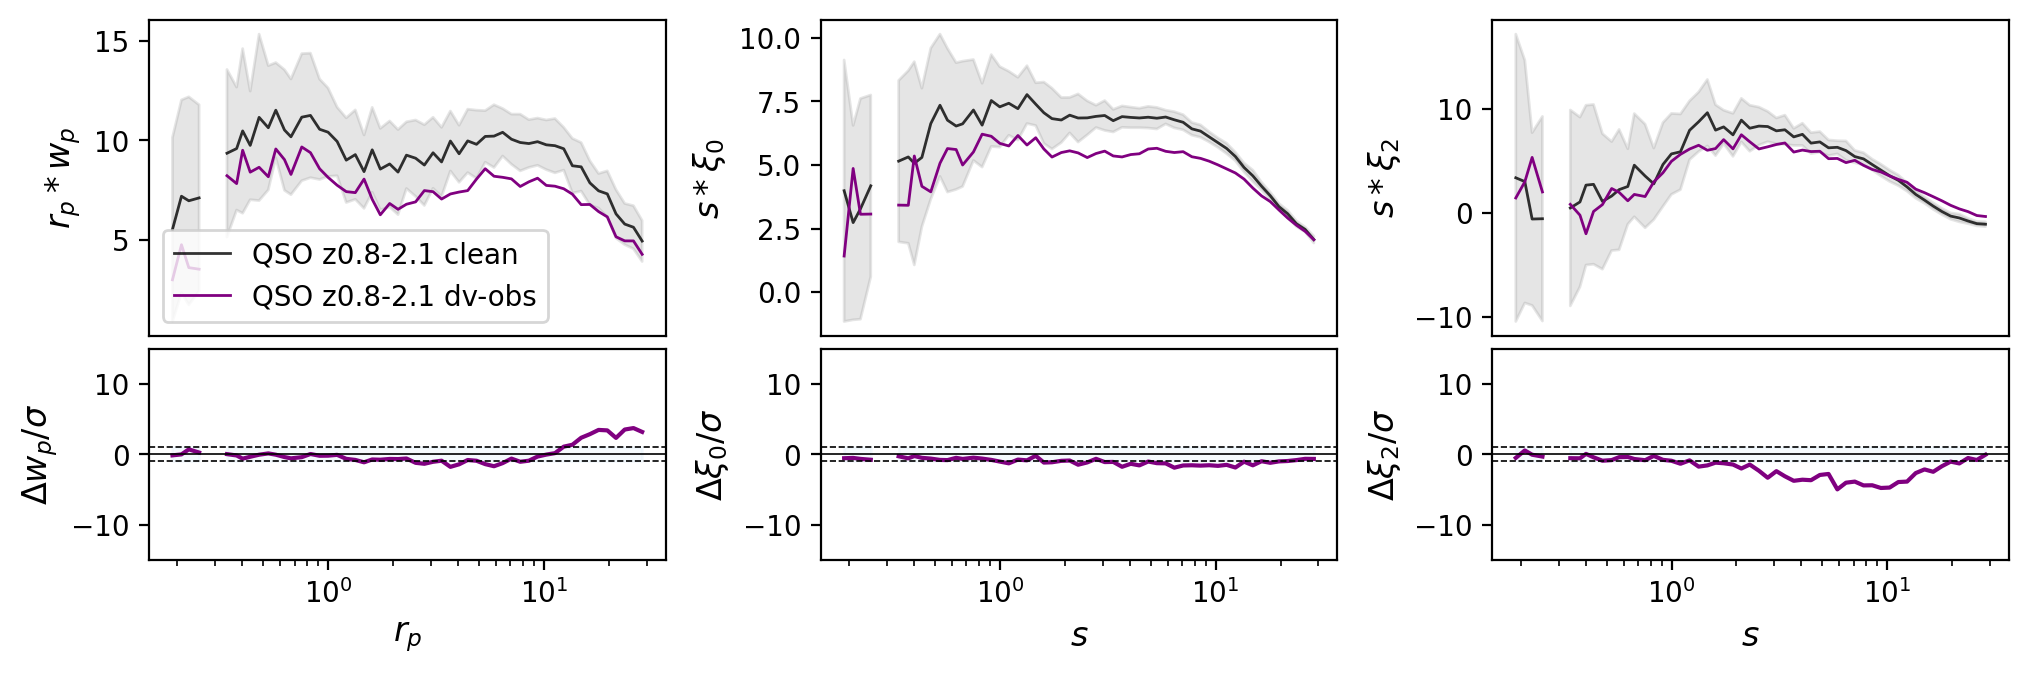

In [ ]:
# PLOT the HOD fitting reference plot
(smin, smax, sbin, slen) = load_bins('mpslog')

sys_models = ['standard','dv-obs']
error_type = 'standard' #standard, covbox, EZcov

tracers = ['QSO']
# tracers = ['ELG']
mockids = range(0,25)

for tracer in tracers:
    for i,(zmin, zmax) in enumerate(Z_VSMEAR[tracer]):
        fig = plt.figure(figsize=(10, 3))
        gs = gridspec.GridSpec(2, 3, wspace=0.3, hspace=0.05,left=0.05, right=0.98, top=0.95, bottom=0.05, height_ratios=[1.5, 1])
        z_eff = Z_CUBIC[tracer][i]
        color = COLOR_TRACERS[tracer][i]
        clus_dv_obs = []
        clus_standard = []
        for sys_model in sys_models:
            for mock_id in mockids:
                mock_id03 =  f"{mock_id:03}"
                base_dir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/{tracer}/obs_z{zmin:.1f}-{zmax:.1f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                # load the xi0 and xi2
                result_fn = base_dir+f'/mpslog_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}.npy'
                result = TwoPointCorrelationFunction.load(result_fn)
                result.select((smin, smax))
                s, mps = project_to_multipoles(result, ells=[0,2])
                # load the wp
                result_fn = base_dir+f'/wplog_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}.npy'
                result = TwoPointCorrelationFunction.load(result_fn)
                result.select((smin, smax))
                p,wp = project_to_wp(result)
                # combine
                clus = np.array([wp,mps[0],mps[1]])
                if sys_model in ['dv-obs']:
                    clus_dv_obs.append(clus)
                if sys_model in ['standard']:
                    clus_standard.append(clus)
        clus_standard = [np.mean(clus_standard, axis=0), np.std(clus_standard, axis=0)]
        clus_dv_obs = [np.mean(clus_dv_obs, axis=0), np.std(clus_dv_obs, axis=0)]
        error = [clus_standard[1][0], clus_standard[1][1], clus_standard[1][2]]
        for r_ind in range(2):
            for c_ind in range(3):
                if r_ind == 0:
                    ax = plt.subplot(gs[c_ind])
                    ax.plot(s, s*clus_standard[0][c_ind],color='black', lw=1.0, label = f'{tracer} z{zmin}-{zmax} clean', alpha=0.8)
                    ax.fill_between(s, s*(clus_standard[0][c_ind]-error[c_ind]), s*(clus_standard[0][c_ind]+error[c_ind]), color='grey', alpha=0.2)
                    ax.plot(s, s*clus_dv_obs[0][c_ind],color=color, lw=1.0, label = f'{tracer} z{zmin}-{zmax} dv-obs')
                    if c_ind == 0:
                        ax.legend(loc=3, fontsize=10)
                    if c_ind == 0:
                        ax.set_ylabel(fr'$r_p*w_p$')
                    if c_ind >0:
                        ax.set_ylabel(fr'$s* \xi_{{}}$'.format((c_ind-1)*2))
                    ax.set_xscale('log')
                    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
                if r_ind == 1:
                    ax = plt.subplot(gs[c_ind+r_ind*3])
                    ax.plot(s, (clus_dv_obs[0][c_ind-1]-clus_standard[0][c_ind-1])/error[c_ind-1],color=color)
                    ax.fill_between(s, -1 , 1, color = '#d1e7f7', alpha=0.2)
                    ax.axhline(y=1, color = 'black', ls='--', lw = 0.6)
                    ax.axhline(y=-1, color = 'black', ls='--', lw = 0.6)
                    ax.axhline(y=0, color='black', lw=0.6)
                    ax.set_ylim([-15,15])
                    ax.set_xscale('log')
                    if c_ind == 0:
                        ax.set_xlabel(r'$r_p$')
                        ax.set_ylabel(fr'$\Delta w_p / \sigma$')
                    if c_ind >0:
                        ax.set_xlabel(r'$s$')
                        ax.set_ylabel(fr'$\Delta \xi_{{}}/\sigma$'.format((c_ind-1)*2))
        fig.savefig(f'./plots/wp_xi_{tracer}_z{zmin}-{zmax}.png',dpi=300, bbox_inches='tight')

/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/EZmocks/covariance/pk/cov_EZmocks_1.5Gpc_pk02_QSO_z0.8-2.1_k0.02-0.2_rsfDR2.txt


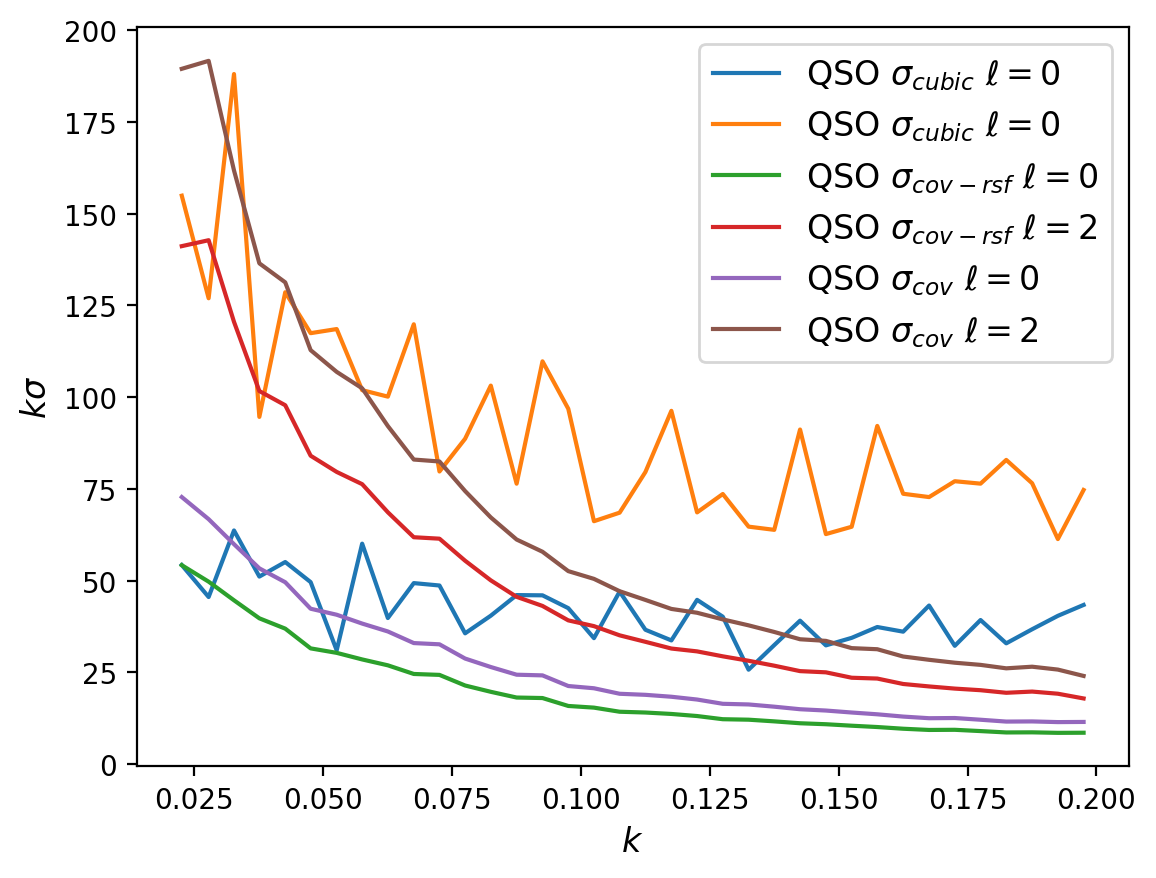

In [48]:
# Plot the CovBox data for error bar reference and covariance maybe
%matplotlib inline
tracer = 'QSO'
bins_type = 'y3_sys'
corr_type = 'pk'
z_eff = REDSHIFT_LSS_CUBICBOX[tracer][0]
(zmin, zmax) = REDSHIFT_LSS_VSMEAR[tracer][0]
data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "sys_model": 'standard', "grid_cosmo": '000'}
fit_args = {"corr_type": corr_type, "bins_type": bins_type, "cov_type": 'EZcov_fn_rsf', "theory_model":'folps'}
cov_mock = load_EZcov_fn(data_args,  cov_type='EZmocks', corr_type = corr_type, bins_type = 'y3_sys', rsf = True)
pk_cov_error = np.sqrt(np.diag(cov_mock))
rsf = RSF_EZMOCKS_ERROR[tracer][Z_VSMEAR[tracer].index((zmin, zmax))]

plt.plot(ks ,ks*pk_standard_error[0],label = r'QSO $\sigma_{cubic} \ \ell =0 $')
plt.plot(ks ,ks*pk_standard_error[1], label = r'QSO $\sigma_{cubic} \ \ell =0 $')
plt.plot(ks ,ks*pk_cov_error[:36], label = r'QSO $\sigma_{cov-rsf} \ \ell =0 $')
plt.plot(ks ,ks*pk_cov_error[36:], label = r'QSO $\sigma_{cov-rsf} \ \ell =2 $')
plt.plot(ks ,ks*pk_cov_error[:36]/rsf, label = r'QSO $\sigma_{cov} \ \ell =0 $')
plt.plot(ks ,ks*pk_cov_error[36:]/rsf, label = r'QSO $\sigma_{cov} \ \ell =2 $')
plt.ylabel(r'$k\sigma$')
plt.xlabel(r'$k$')
plt.legend()

In [25]:
pk_cov_error

array([2403.04013041, 1790.54395041, 1365.82978577, 1056.76658945,
        866.32864039,  663.56035745,  576.59351281,  495.98517951,
        430.7969346 ,  363.86303765,  335.42810689,  276.61742175,
        239.07800294,  207.59065924,  194.84691278,  162.72682525,
        150.37526408,  133.01732264,  125.19773225,  116.52097149,
        107.15410583,   96.16716412,   91.55386673,   84.93606212,
         78.32786857,   73.86745467,   68.81252992,   64.34823529,
         59.50773872,   55.74016656,   54.36450464,   50.86633117,
         47.43449101,   46.32566541,   44.41136203,   43.45275106,
       6254.60415343, 5139.50544363, 3685.59860958, 2702.63686548,
       2293.69598974, 1766.95335195, 1513.2502137 , 1325.5338305 ,
       1097.36467129,  915.08079609,  846.81458744,  715.05633729,
        607.04013143,  521.02867014,  465.96622843,  401.74021131,
        366.90449594,  326.61477462,  296.39258412,  268.13362556,
        250.87539431,  230.50110928,  212.68276715,  195.23493

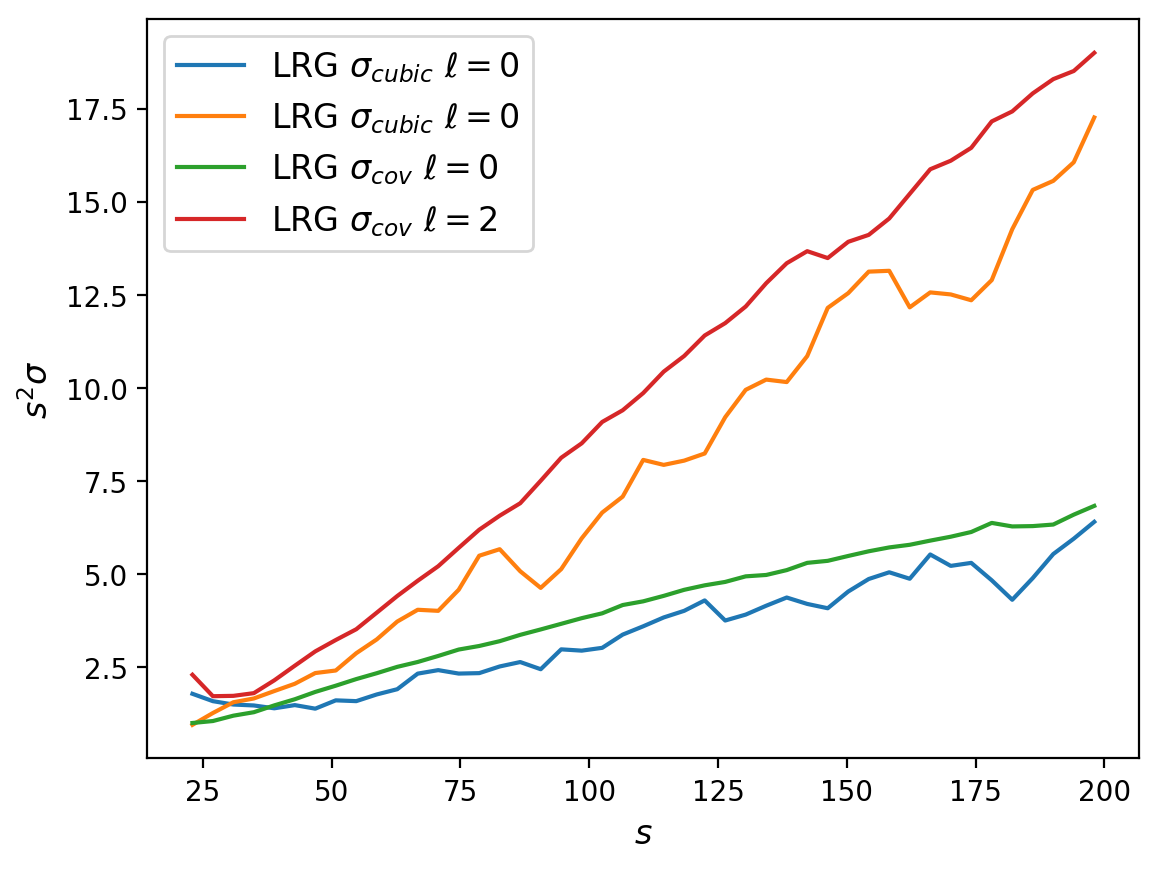

In [ ]:
# Plot the CovBox data for error bar reference and covariance maybe
corr = 'xi'
boxsize = 500.
tracer = tracers[0]
Z_CUBIC = REDSHIFT_CUBICBOX[tracer][0]
(zmin, zmax) = REDSHIFT_VSMEAR[tracer][0]
xi_ = []
mockids = np.arange(3000,4500)
# for Z_CUBIC, (zmin, zmax) in zip(REDSHIFT_CUBICBOX[tracer], REDSHIFT_VSMEAR[tracer]):
for mock_id in mockids:
    mock_id04 =  f"{mock_id:04}"
    base_dir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CovBox'
    data_fn = base_dir+ f'/{tracer}/z{Z_CUBIC:.3f}/xi/xipoles_{tracer}_z{Z_CUBIC:.1f}_ph{mock_id04}.npy'
    if corr == 'pk':
        data_fn = base_dir+ f'/{tracer}/z{Z_CUBIC:.3f}/pk/pkpoles_{tracer}_z{Z_CUBIC:.1f}_ph{mock_id04}.npy'
    if not os.path.isfile(data_fn):
        # print(f"File not found: {data_fn}. Skipping mock_id={mock_id04}")
        continue
    result = TwoPointCorrelationFunction.load(data_fn)
    result = result[::rbin,::]
    result.select((rmin, rmax))
    s, xi = project_to_multipoles(result, ells=[0,2])
    xi_.append(xi)
error = np.std(xi_, axis=0)
rsf = RSF_COV_ERROR[tracer]
plt.plot(s ,s**2*xi_standard_error[0],label = r'LRG $\sigma_{cubic} \ \ell=0 $')
plt.plot(s ,s**2*xi_standard_error[1], label = r'LRG $\sigma_{cubic} \ \ell=0 $')
plt.plot(s ,s**2*error[0]*rsf, label = r'LRG $\sigma_{cov} \ \ell =0 $')
plt.plot(s ,s**2*error[1]*rsf, label = r'LRG $\sigma_{cov} \ \ell =2 $')
plt.ylabel(r'$s^2\sigma$')
plt.xlabel(r'$s$')
plt.legend()

### pre and post reconstruciton

/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/glob

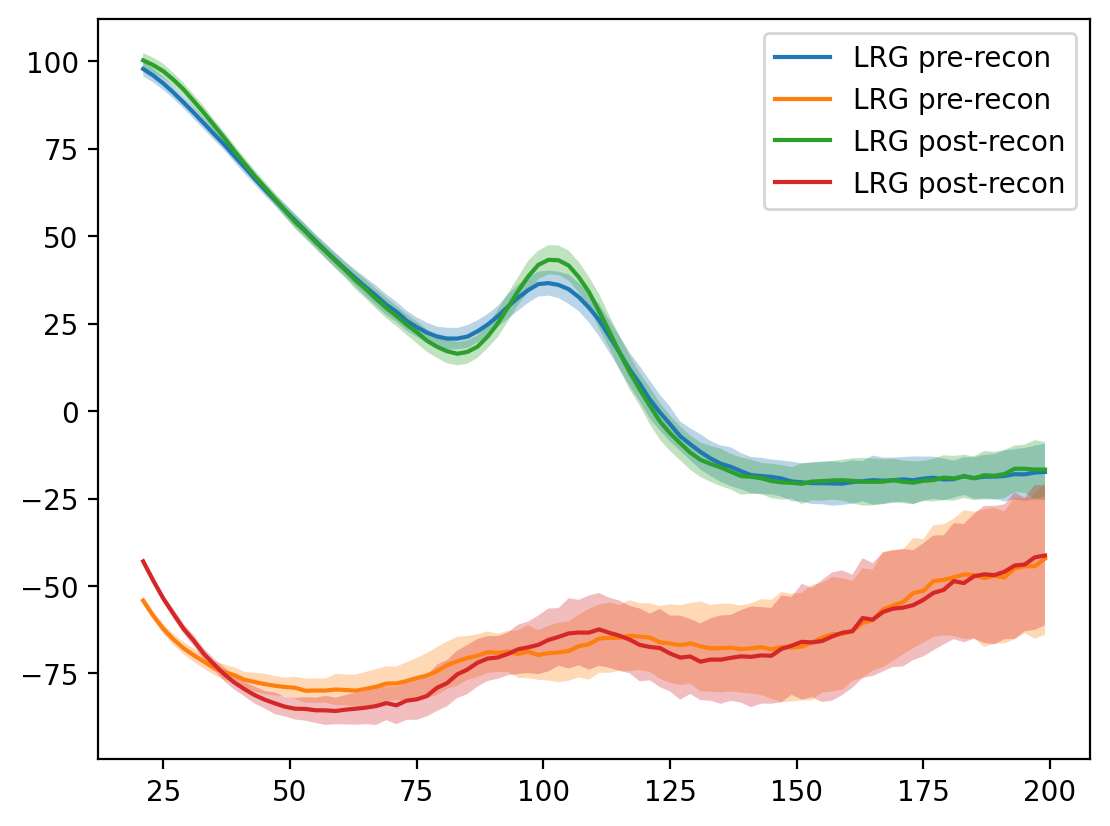

In [23]:
%matplotlib inline
bins_type = 'y3_bao'
setup_logging(level = 'warning')
plt.rcParams['legend.fontsize'] = 10
(rmin, rmax, rbin, lenr) = load_bins('test', 'xi')
boxsize = 2000.

smuedges  = (np.linspace(1., 200, 201), np.linspace(-1., 1., 201))
tracer = 'LRG'
(zmin, zmax) = REDSHIFT_VSMEAR[tracer][0]
z_eff = REDSHIFT_CUBICBOX[tracer][0]

labels = ['pre-recon', 'post-recon']
for label , recon in zip(labels, [False, True]):
    xi_dv_obs = []
    xi_standard = []
    for sys_model in ['standard']:
        for id in range(25):
            mock_id03 =  f"{id:03}"
            basedir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/{tracer}/obs_z{zmin:.1f}-{zmax:.1f}/AbacusSummit_base_c000_ph{mock_id03}'
            if recon == False:
                catalog_fn = basedir+f'/mpspk/xipoles_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}.npy'
            elif recon == True:
                catalog_fn = basedir+f'/mpspk/xipoles_recon_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}.npy'
            result = TwoPointCorrelationFunction.load(catalog_fn)
            result = result[::2,::]
            result.select((rmin, rmax))
            s, xi = project_to_multipoles(result, ells=[0,2])
            if sys_model in ['dv-obs']:
                xi_dv_obs.append(xi)
            if sys_model in ['standard']:
                xi_standard.append(xi)

    xi_standard = [np.mean(xi_standard, axis=0), np.std(xi_standard, axis=0)]
    xi_dv_obs = [np.mean(xi_dv_obs, axis=0), np.std(xi_dv_obs, axis=0)]
    xi_error = [xi_standard[1][0], xi_standard[1][1]]
    ell = 0
    plt.plot(s, s**2*xi_standard[0][ell], label = f'{tracer} {label}')
    # plt.plot(s, s**2*xi_dv_obs[0][ell], label = f'{tracer} dv {label}')
    plt.fill_between(s, s**2 * (xi_standard[0][ell]+xi_error[ell]), s**2*(xi_standard[0][ell]-xi_error[ell]), alpha = 0.3)

    ell = 1
    plt.plot(s, s**2*xi_standard[0][ell], label = f'{tracer} {label}')
    # plt.plot(s, s**2*xi_dv_obs[0][ell], label = f'{tracer} dv {label}')
    plt.fill_between(s, s**2 * (xi_standard[0][ell]+xi_error[ell]), s**2*(xi_standard[0][ell]-xi_error[ell]), alpha = 0.3)
    plt.legend()

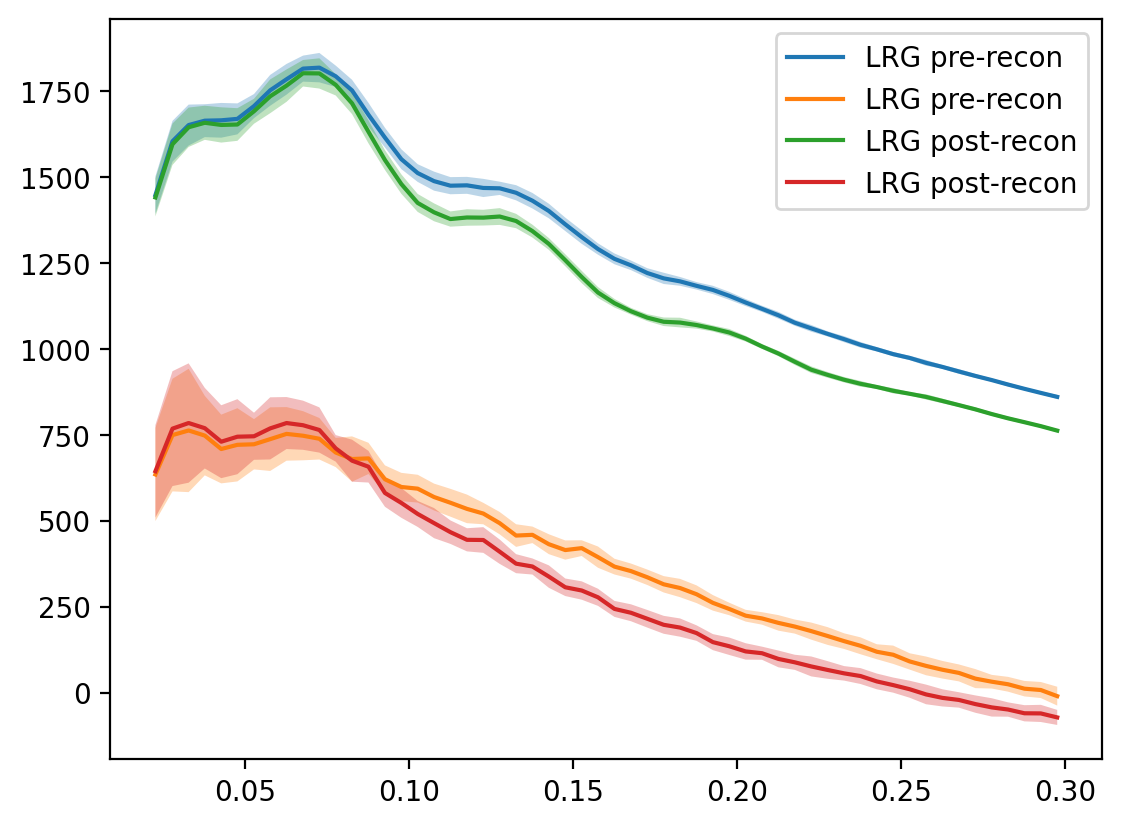

In [24]:
%matplotlib inline
setup_logging(level = 'warning')
plt.rcParams['legend.fontsize'] = 10
(kmin, kmax, kbin, lenk) = load_bins(bins_type, 'pk')
boxsize = 2000.

smuedges  = (np.linspace(1., 200, 201), np.linspace(-1., 1., 201))
tracer = 'LRG'
(zmin, zmax) = REDSHIFT_VSMEAR[tracer][0]
z_eff = REDSHIFT_CUBICBOX[tracer][0]

labels = ['pre-recon', 'post-recon']
for label , recon in zip(labels, [False, True]):
    pk_dv_obs = []
    pk_standard = []
    for sys_model in ['standard', 'dv-obs']:
        for id in range(25):
            mock_id03 =  f"{id:03}"
            basedir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/{tracer}/obs_z{zmin:.1f}-{zmax:.1f}/AbacusSummit_base_c000_ph{mock_id03}'
            if recon == False:
                catalog_fn = basedir+f'/mpspk/pkpoles_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}.npy'
            elif recon == True:
                catalog_fn = basedir+f'/mpspk/pkpoles_recon_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}.npy'
            result = PowerSpectrumMultipoles.load(catalog_fn)
            result = result.select((kmin,kmax,kbin))
            pk = np.real(result.get_power())
            ks = result.kavg
            if sys_model in ['dv-obs']:
                pk_dv_obs.append(pk)
            if sys_model in ['standard']:
                pk_standard.append(pk)
    pk_standard = [np.mean(pk_standard, axis=0), np.std(pk_standard, axis=0)]
    pk_dv_obs = [np.mean(pk_dv_obs, axis=0), np.std(pk_dv_obs, axis=0)]
    pk_standard_error = [pk_standard[1][0], pk_standard[1][1]]

    ell = 0
    plt.plot(ks, ks*pk_standard[0][ell], label = f'{tracer} {label}')
    # plt.plot(ks, ks*pk_dv_obs[0][ell], label = f'{tracer} dv {label}', color = 'C1')
    plt.fill_between(ks, ks * (pk_standard[0][ell]+pk_standard[1][ell]), ks*(pk_standard[0][ell]-pk_standard[1][ell]), alpha = 0.3)
    
    ell = 1
    plt.plot(ks, ks*pk_standard[0][ell], label = f'{tracer} {label}')
    # plt.plot(ks, ks*pk_dv_obs[0][ell], label = f'{tracer} dv {label}', color = 'C1')
    plt.fill_between(ks, ks * (pk_standard[0][ell]+pk_standard[1][ell]), ks*(pk_standard[0][ell]-pk_standard[1][ell]), alpha = 0.3)
    plt.legend()

[000000.04]  02-18 05:15  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000000.04]  02-18 05:15  TwoPointCorrelationFunction  INFO     Running auto-correlation.
[000000.04]  02-18 05:15  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000000.77]  02-18 05:15  TwoPointCorrelationFunction  INFO     Analytically computing two-point counts R1R2.
[000000.77]  02-18 05:15  TwoPointCorrelationFunction  INFO     Correlation function computed in elapsed time 0.73 s.
[000000.83]  02-18 05:15  IterativeFFTReconstruction   INFO     Using mesh with nmesh=[100 100 100], boxsize=[2000. 2000. 2000.], boxcenter=[0. 0. 0.].
[000000.83]  02-18 05:15  IterativeFFTReconstruction   INFO     Slab 0 ~ 4194304 / 218809.
[000001.00]  02-18 05:15  IterativeFFTReconstruction   INFO     Painted 218809 out of 218809 objects to mesh.
[000001.03]  02-18 05:15  IterativeFFTReconstruction   INFO     Running iteration 0.
[0000

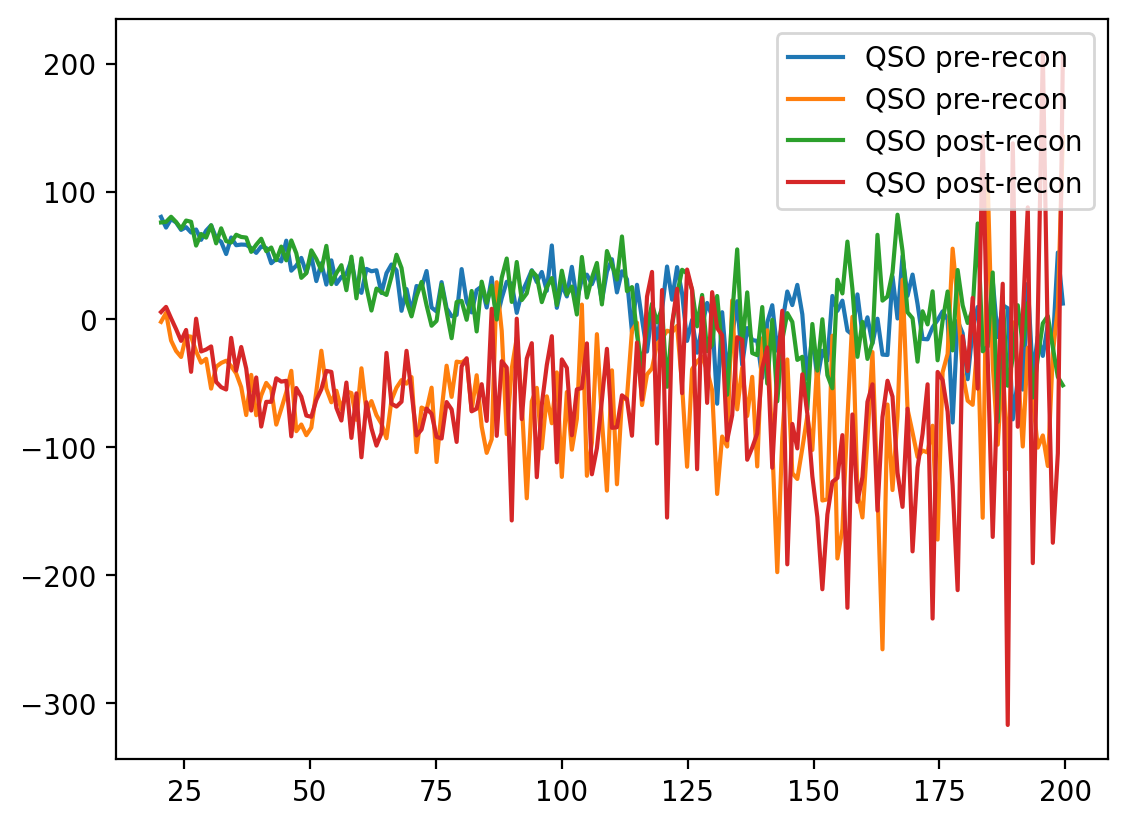

In [ ]:
### Run reconstruction
%matplotlib inline
from pyrecon import MultiGridReconstruction, IterativeFFTReconstruction, IterativeFFTParticleReconstruction, utils, setup_logging
setup_logging()
plt.rcParams['legend.fontsize'] = 10
(rmin, rmax, rbin, lenr) = load_bins('test', 'xi')
boxsize = 2000.

smuedges  = (np.linspace(1., 200, 201), np.linspace(-1., 1., 201))
tracer = 'QSO'
(zmin, zmax) = REDSHIFT_VSMEAR[tracer][0]
z_eff = REDSHIFT_CUBICBOX[tracer][0]
basedir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/{tracer}/obs_z{zmin:.1f}-{zmax:.1f}/AbacusSummit_base_c000_ph000'

for sysmodel in ['standard']:
# for sysmodel in ['standard', 'dv-obs']:
    # for recon in ['pre-recon', ]:
    labels = ['pre-recon', 'post-recon']
    for label , recon in zip(labels, [False, True]):
        data_fn = basedir+f'/catalog_rsd_xi2d_{tracer}_z{zmin:.1f}-{zmax:.1f}_velbias_B_s_mockcov.fits'
        data = Catalog.read(data_fn)
        if sysmodel == 'standard':
            data_positions = np.array([data['x'],data['y'], data['z']%boxsize-boxsize/2.0])
        elif sysmodel == 'dv-obs':
            data_positions = np.array([data['x'],data['y'], data['z_dv']])
        if recon == False:
            result = TwoPointCorrelationFunction('smu', smuedges, data_positions1=data_positions, 
                                                boxsize=2000., position_type='xyz', engine='corrfunc', 
                                                nthreads=256, los='z')
        elif recon == True:
            f, bias, s = GET_RECON_BIAS(tracer = tracer, grid_cosmo = '000')
            Reconstruction = {'IFFT': IterativeFFTReconstruction, 'IFFTP': IterativeFFTParticleReconstruction, 'MG': MultiGridReconstruction}['IFFT']
            recon = Reconstruction(f=f, bias=bias, los='z', cellsize=20., boxsize=2000., boxcenter = [0,0,0], position_type='xyz', dtype='f8')
            recon.assign_data(data_positions)
            recon.set_density_contrast(smoothing_radius=s)
            recon.run()
            data_positions_rec = recon.read_shifted_positions(data_positions, field='disp+rsd' , dtype='f8')

            shifted_positions1 = []
            for i in range(4):
                randoms = RandomBoxCatalog(boxsize=boxsize, csize=data.csize)
                randoms_positions = randoms.get('Position').T
                del randoms['Position']
                randoms_positions_rec = recon.read_shifted_positions(randoms_positions, field='disp+rsd', dtype='f8')
                shifted_positions1.append(randoms_positions_rec)
            shifted_positions1 = np.concatenate(shifted_positions1, axis=1)
            result = TwoPointCorrelationFunction('smu', smuedges, data_positions1=data_positions_rec,
                                                 shifted_positions1 = shifted_positions1, 
                                                boxsize=2000., position_type='xyz', engine='corrfunc', 
                                                nthreads=256, los='z')
        result = result[::1,::]
        result.select((rmin, rmax))
        s, xi = project_to_multipoles(result, ells=[0,2])
        plt.plot(s, s**2*xi[0], label = f'{tracer} {label}')
        plt.plot(s, s**2*xi[1], label = f'{tracer} {label}')
        plt.legend(loc = 1)